In [141]:
# coding: UTF-8
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
from tkinter import scrolledtext 
from rdflib import Graph, RDFS, URIRef, Namespace, RDF, Literal

import networkx as nx
from PIL import Image, ImageTk
import matplotlib.pyplot as plt

import copy
import string
import random
import datetime
import re

import ScrollableFrame
import FusekiManagement
import Neo4jConnection as neo4j

import importlib
importlib.reload(ScrollableFrame)
importlib.reload(FusekiManagement)
importlib.reload(neo4j)

<module 'Neo4jConnection' from 'c:\\wan\\pythonファイル\\DigitalTriplet_0513\\Neo4jConnection.py'>

In [142]:
class Application(tk.Frame):
    """ メインアプリケーションクラス

    """
    # treeview Widgetの情報を格納する変数
    treeview = None

    def __init__(self, master=None):
        """  メインウィンドウの初期設定を行う

        Args:
            master:

        """
        super().__init__(master)
        self.master = master
        self.master.title("GPM Window")
        # メニューバー作成 
        self.set_menubar()
        self.frame = ScrollableFrame.ScrollableFrame(self.master, canvas_width=1120, \
                                                    canvas_height=585, frame_width=1260, \
                                                    frame_height=760)
        self.frame.pack()
        # タブ設定
        self.set_tab()

        self.fuseki_url = "http://localhost:3030/"
        self.fuseki_database_name = "akiyama"
        self.prefix_grpah_data = {}
        self.ttl_file = "ttl_file.ttl"
        self.selected_graph = None
        self.selected_graph_name = None
        self.gpm_uri = None
        self.graph_node_list = []
        self.graph_edge_list = []
        self.graph_label_list = {}
        self.graph_position = {}
        # ------------------------------
        # ログウィンドウ
        # ------------------------------
        # ログウインドウで選択したグラフ
        self.log_graph = tk.StringVar()
        # ログウインドウで選択したノード
        self.log_node = tk.StringVar()
        # ログウインドウで選択したuri
        self.log_uri = tk.StringVar()
        # ------------------------------
        # ウィンドウ2
        # ------------------------------
        # ウインドウ2で選択したグラフ
        self.win2_graph = tk.StringVar()
        # ウインドウ2で選択したノード
        self.win2_selected_item = tk.StringVar()
        # ウインドウ2で選択したuri
        self.win2_uri = tk.StringVar()

        # 表示しているグラフの層を記録
        self.graph_level = None
        # Neo4jConnectionインスタンス生成
        self.sam = neo4j.Neo4jConnection(uri="neo4j+s://626f138b.databases.neo4j.io:7687", user="neo4j",\
                                        pwd="oDT19HljLv2kawCSea7jena-75Rycv6UNbDM37Gq2Go")
        self.create_widgets()

    def set_menubar(self):
        """  メニューバー作成

        """
        menubar = tk.Menu(self.master) 
        root.config(menu=menubar) 
        # Functionメニュー
        menu_function = tk.Menu(self.master, tearoff=0) 
        menubar.add_cascade(label="Execute", menu=menu_function)
        con_menu = tk.Menu(menu_function, tearoff=0)
        menu_function.add_cascade(label="コンテナ関連付け",menu=con_menu)
        con_menu.add_command(label="Open Window", command=self.open_window_2)
        con_menu.add_separator() 
        con_menu.add_command(label="EP全体をメンバー関連付け追加", \
                                    command=self.insert_ep_member_event)
        con_menu.add_command(label="コンテナのみをメンバー関連付け追加", \
                                    command=self.insert_con_member_event)
        con_menu.add_command(label="削除", command=self.delete_member_event)

        use_menu = tk.Menu(menu_function, tearoff=0)
        menu_function.add_cascade(label="Use関連付け",menu=use_menu)
        use_menu.add_command(label="Open Log Window", command=self.open_log_window)
        use_menu.add_separator() 
        use_menu.add_command(label="追加", command=self.insert_use_event)
        use_menu.add_command(label="削除", command=self.delete_use_event)

        # Searchメニュー
        menu_search = tk.Menu(self.master, tearoff=0) 
        menubar.add_cascade(label="Search", menu=menu_search)
        menu_search.add_command(label='知識文書検索', command= \
                                self.insert_document_list)
        menu_search.add_command(label='技術者検索', command= \
                                self.insert_engineer_list)
        menu_search.add_command(label='過去事例検索', command= \
                                self.insert_lld_list)
        menu_search.add_command(label='SAM因子検索', command= \
                                self.insert_samfactor_list)

        # Exportメニュー
        menu_export = tk.Menu(self.master, tearoff=0) 
        menubar.add_cascade(label="Export", menu=menu_export)
        menu_export.add_command(label='Graph Export', command=lambda: \
                                FusekiManagement.fuseki_export(self))
        menu_export.add_command(label='Fuseki all Export', command=lambda: \
                                FusekiManagement.fuseki_export_all(self)) 

    def set_tab(self):
        """  タブ作成

        """
        style = ttk.Style()
        style.configure('One.TNotebook.Tab',font=('Arial', 8), padding=0)

        book_graph = ttk.Notebook(self.frame.scrollable_frame, style='One.TNotebook', width=650)
        book_graph.place(x=0, y=0)
        self.frame_tab_graph = ttk.Frame(book_graph, width=650, height=560, relief="groove")
        book_graph.add(self.frame_tab_graph, text="Graph")

        self.book_action = ttk.Notebook(self.frame.scrollable_frame, style='Ono.TNotebook', width=470)
        self.book_action.place(x=650, y=-1)
        self.frame_tab_action = ttk.Frame(self.book_action, width=470, height=560, relief="groove")
        self.book_action.add(self.frame_tab_action, text='Action')
        self.frame_tab_edge = ttk.Frame(self.book_action, width=470, height=560, relief="groove")
        self.book_action.add(self.frame_tab_edge , text='Edge')
        self.frame_tab_search = ttk.Frame(self.book_action, width=470, height=560, relief="groove")
        self.book_action.add(self.frame_tab_search , text='Search')

    def create_widgets(self):
        """ ウィジェットを作成

        """
        # ------------------------------------------------------------------
        # LabelFrame
        # ------------------------------------------------------------------
        self.create_frame_widget()
        # ------------------------------------------------------------------
        # listbox widget (Graph Info)
        # ------------------------------------------------------------------
        self.scrollbar_ep_info_x = tk.Scrollbar(self.frame_ep_info_list, \
                                                orient=tk.HORIZONTAL)
        self.scrollbar_ep_info_x.pack(side="bottom", fill="x")
        self.scrollbar_ep_info_y = tk.Scrollbar(self.frame_ep_info_list, \
                                                orient=tk.VERTICAL)
        self.scrollbar_ep_info_y.pack(side="right", fill="y")

        self.listbox_ep_value = tk.StringVar()
        self.listbox_ep_info = tk.Listbox(self.frame_ep_info_list, height=12, width=25, \
                                        selectmode=tk.SINGLE, \
                                        listvariable=self.listbox_ep_value, \
                                        exportselection=False, \
                                        xscrollcommand=self.scrollbar_ep_info_x.set, \
                                        yscrollcommand=self.scrollbar_ep_info_y.set)
        self.listbox_ep_info.pack(fill="both")
        self.listbox_ep_info.bind("<<ListboxSelect>>", self.select_graph)

        self.scrollbar_ep_info_x.config(command=self.listbox_ep_info.xview)
        self.scrollbar_ep_info_y.config(command=self.listbox_ep_info.yview)
        # ------------------------------------------------------------------
        # treeview widget
        # ------------------------------------------------------------------
        self.treeview = ttk.Treeview(self.frame_hierarchy_list, height=13)
        # 階層列設定
        self.treeview.column("#0", width=160, minwidth=500)
        # 階層列(ツリーカラム)の見出し設定。階層列とする。
        self.treeview.heading("#0")
        self.treeview.bind("<<TreeviewSelect>>", self.tree_select)
        self.treeview.grid(row=1, column=1, sticky="nsew")

        tree_scrollbar_y = ttk.Scrollbar(self.frame_hierarchy_list, orient="vertical", \
                                        command=self.treeview.yview)
        tree_scrollbar_y.grid(row=1, column=2, sticky="nsew")
        self.treeview.configure(yscrollcommand=tree_scrollbar_y.set)

        tree_scrollbar_x = ttk.Scrollbar(self.frame_hierarchy_list, orient="horizontal", \
                                        command=self.treeview.xview)
        tree_scrollbar_x.grid(row=2, column=1, sticky="nsew")
        self.treeview.configure(xscrollcommand=tree_scrollbar_x.set)
        # ------------------------------------------------------------------
        # ノード情報ウィジェットを作成
        # ------------------------------------------------------------------
        self.create_node_info_widget()
        # ------------------------------------------------------------------
        # listbox widget (GPM uri Info)
        # ------------------------------------------------------------------
        self.scrollbar_gpm_uri_list_x = tk.Scrollbar(self.frame_new_gpm_list, \
                                                    orient=tk.HORIZONTAL)
        self.scrollbar_gpm_uri_list_x.pack(side="bottom", fill="x")
        self.scrollbar_gpm_uri_list_y = tk.Scrollbar(self.frame_new_gpm_list, \
                                                    orient=tk.VERTICAL)
        self.scrollbar_gpm_uri_list_y.pack(side="right", fill="y")

        self.listbox_gpm_uri_list = tk.Listbox(self.frame_new_gpm_list, height=12, \
                                            width=25, selectmode=tk.SINGLE, \
                                            exportselection=False, \
                                            xscrollcommand=self.scrollbar_gpm_uri_list_x.set, \
                                            yscrollcommand=self.scrollbar_gpm_uri_list_y.set)
        self.listbox_gpm_uri_list.pack(fill="both")

        self.scrollbar_gpm_uri_list_x.config(command=self.listbox_gpm_uri_list.xview)
        self.scrollbar_gpm_uri_list_y.config(command=self.listbox_gpm_uri_list.yview)
        # ------------------------------------------------------------------
        # listbox widget (object list)
        # ------------------------------------------------------------------
        self.scrollbar_object_x = tk.Scrollbar(self.frame_object_list, \
                                            orient=tk.HORIZONTAL)
        self.scrollbar_object_x.pack(side="bottom", fill="x")
        self.scrollbar_object_y = tk.Scrollbar(self.frame_object_list, \
                                            orient=tk.VERTICAL)
        self.scrollbar_object_y.pack(side="right", fill="y")

        self.listbox_object = tk.Listbox(self.frame_object_list, height=11, width=26, \
                                        selectmode=tk.SINGLE, exportselection=False, \
                                        xscrollcommand=self.scrollbar_object_x.set, \
                                        yscrollcommand=self.scrollbar_object_y.set)
        self.listbox_object.pack(fill="both")
        self.listbox_object.bind("<<ListboxSelect>>", self.select_object)

        self.scrollbar_object_x.config(command=self.listbox_object.xview)
        self.scrollbar_object_x.config(command=self.listbox_object.yview)
        # ------------------------------------------------------------------
        # listbox widget (Document)
        # ------------------------------------------------------------------
        self.scrollbar_document_x = tk.Scrollbar(self.frame_document_list, \
                                                orient=tk.HORIZONTAL)
        self.scrollbar_document_x.pack(side="bottom", fill="x")
        self.scrollbar_document_y = tk.Scrollbar(self.frame_document_list, \
                                                orient=tk.VERTICAL)
        self.scrollbar_document_y.pack(side="right", fill="y")

        self.listbox_document = tk.Listbox(self.frame_document_list, height=12, width=25, \
                                        selectmode=tk.SINGLE, listvariable='', \
                                        exportselection=False, \
                                        xscrollcommand=self.scrollbar_document_x.set, \
                                        yscrollcommand=self.scrollbar_document_y.set)
        self.listbox_document.pack(fill="both")
        # self.listbox_document.bind("<<ListboxSelect>>", select_graph)

        self.scrollbar_document_x.config(command=self.listbox_document.xview)
        self.scrollbar_document_y.config(command=self.listbox_document.yview)
        # ------------------------------------------------------------------
        # listbox widget (Engineer)
        # ------------------------------------------------------------------
        self.scrollbar_engineer_x = tk.Scrollbar(self.frame_engineer_list, \
                                                orient=tk.HORIZONTAL)
        self.scrollbar_engineer_x.pack(side="bottom", fill="x")
        self.scrollbar_engineer_y = tk.Scrollbar(self.frame_engineer_list, \
                                                orient=tk.VERTICAL)
        self.scrollbar_engineer_y.pack(side="right", fill="y")

        self.listbox_engineer = tk.Listbox(self.frame_engineer_list, height=12, width=25, \
                                        selectmode=tk.SINGLE, listvariable='', \
                                        exportselection=False, \
                                        xscrollcommand=self.scrollbar_engineer_x.set, \
                                        yscrollcommand=self.scrollbar_engineer_y.set)
        self.listbox_engineer.pack(fill="both")
        # self.listbox_engineer.bind("<<ListboxSelect>>", select_graph)

        self.scrollbar_engineer_x.config(command=self.listbox_engineer.xview)
        self.scrollbar_engineer_y.config(command=self.listbox_engineer.yview)
        # ------------------------------------------------------------------
        # listbox widget (LLD)
        # ------------------------------------------------------------------
        self.scrollbar_lld_x = tk.Scrollbar(self.frame_lld_list, \
                                            orient=tk.HORIZONTAL)
        self.scrollbar_lld_x.pack(side="bottom", fill="x")
        self.scrollbar_lld_y = tk.Scrollbar(self.frame_lld_list, \
                                            orient=tk.VERTICAL)
        self.scrollbar_lld_y.pack(side="right", fill="y")

        self.listbox_lld_value = tk.StringVar()
        self.listbox_lld = tk.Listbox(self.frame_lld_list, height=12, width=25, \
                                    selectmode=tk.SINGLE, listvariable='', \
                                    exportselection=False, \
                                    xscrollcommand=self.scrollbar_lld_x.set, \
                                    yscrollcommand=self.scrollbar_lld_y.set)
        self.listbox_lld.pack(fill="both")
        # self.listbox_lld.bind("<<ListboxSelect>>", select_graph)

        self.scrollbar_lld_x.config(command=self.listbox_lld.xview)
        self.scrollbar_lld_y.config(command=self.listbox_lld.yview)
        # ------------------------------------------------------------------
        # listbox widget (SAM factor)
        # ------------------------------------------------------------------
        self.scrollbar_samfactor_x = tk.Scrollbar(self.frame_samfactor_list, \
                                            orient=tk.HORIZONTAL)
        self.scrollbar_samfactor_x.pack(side="bottom", fill="x")
        self.scrollbar_samfactor_y = tk.Scrollbar(self.frame_samfactor_list, \
                                            orient=tk.VERTICAL)
        self.scrollbar_samfactor_y.pack(side="right", fill="y")

        self.listbox_samfactor = tk.Listbox(self.frame_samfactor_list, height=12, width=25, \
                                    selectmode=tk.SINGLE, listvariable='', \
                                    exportselection=False, \
                                    xscrollcommand=self.scrollbar_samfactor_x.set, \
                                    yscrollcommand=self.scrollbar_samfactor_y.set)
        self.listbox_samfactor.pack(fill="both")
        # self.listbox_lld.bind("<<ListboxSelect>>", select_graph)

        self.scrollbar_samfactor_x.config(command=self.listbox_samfactor.xview)
        self.scrollbar_samfactor_y.config(command=self.listbox_samfactor.yview)
        # ------------------------------------------------------------------
        # listbox widget (edge list)
        # ------------------------------------------------------------------
        self.scrollbar_edge_x = tk.Scrollbar(self.frame_edge_list, \
                                            orient=tk.HORIZONTAL)
        self.scrollbar_edge_x.pack(side="bottom", fill="x")
        self.scrollbar_edge_y = tk.Scrollbar(self.frame_edge_list, \
                                            orient=tk.VERTICAL)
        self.scrollbar_edge_y.pack(side="right", fill="y")

        self.listbox_edge = tk.Listbox(self.frame_edge_list, height=12, width=40, \
                                    selectmode=tk.SINGLE, listvariable='', \
                                    exportselection=False, \
                                    xscrollcommand=self.scrollbar_edge_x.set, \
                                    yscrollcommand=self.scrollbar_edge_y.set)
        self.listbox_edge.pack(fill="both")
        # self.listbox_lld.bind("<<ListboxSelect>>", select_graph)

        self.scrollbar_edge_x.config(command=self.listbox_edge.xview)
        self.scrollbar_edge_y.config(command=self.listbox_edge.yview)
        # ------------------------------------------------------------------
        # Button widget
        # ------------------------------------------------------------------
        # 表示EPを設定
        self.button_gpm_set = tk.Button(self.frame_button, text=" 表示 ", width=8, \
                                        height=2, command=self.set_gpm)
        self.button_gpm_set.grid(row=1, column=0, padx=5)
        # ------------------------------------------------------------------
        # label
        # ------------------------------------------------------------------
        self.label_log_graph = tk.Label(self.frame_button, textvariable=self.log_graph)
        self.label_log_uri = tk.Label(self.frame_button, textvariable=self.log_uri)
        self.label_log_node = tk.Label(self.frame_button, textvariable=self.log_node)
        # ------------------------------------------------------------------
        # canvas
        # ------------------------------------------------------------------
        self.graph_canvas = tk.Canvas(self.frame_tab_graph)
        self.graph_canvas.place(x=5, y=5, width=455, height=550)
        # canvas スクロールバー
        self.canvas_bar_y = tk.Scrollbar(self.graph_canvas, orient=tk.VERTICAL)
        self.canvas_bar_x = tk.Scrollbar(self.graph_canvas, orient=tk.HORIZONTAL)
        self.canvas_bar_y.pack(side=tk.RIGHT, fill=tk.Y)
        self.canvas_bar_x.pack(side=tk.BOTTOM, fill=tk.X)
        self.canvas_bar_y.config(command=self.graph_canvas.yview)
        self.canvas_bar_x.config(command=self.graph_canvas.xview)
        self.graph_canvas.config(yscrollcommand=self.canvas_bar_y.set, \
                                xscrollcommand=self.canvas_bar_x.set)
        # Canvasのスクロール範囲を設定
        self.graph_canvas.config(scrollregion=(5, 5, 1000, 1000))

        # graphを取得し、リストボックスに設定
        (self.graph_url_list, self.graph_list) = FusekiManagement.get_graph(self.fuseki_url)
        self.listbox_ep_value.set(self.graph_list)

    def create_frame_widget(self):
        """ LabelFrameを作成

        """
        # 共通設定
        frame_options = {"bd": 2, "relief": "ridge", "foreground": "green"}
        # graph info
        self.frame_ep_info_list = tk.LabelFrame(self.frame_tab_graph, \
                                                text=" Graph Info", width=300, \
                                                height=120, **frame_options)
        self.frame_ep_info_list.place(x=465, y=5)
        # Top Level URI List
        self.frame_new_gpm_list = tk.LabelFrame(self.frame_tab_graph, \
                                                text="Top Level EP List", width=300, \
                                                height=200, **frame_options)
        self.frame_new_gpm_list.place(x=465, y=240)
        # node list
        self.frame_hierarchy_list = tk.LabelFrame(self.frame_tab_action, \
                                                text="Action List", width=300, \
                                                height=240, **frame_options)
        self.frame_hierarchy_list.place(x=5, y=5)
        # node info
        self.frame_node = tk.LabelFrame(self.frame_tab_action, text="Information", \
                                        width=300, height=300, **frame_options)
        self.frame_node.place(x=195, y=5)
        # id
        self.frame_id_info = tk.LabelFrame(self.frame_node, width=300, height=300, \
                                        **frame_options)
        self.frame_id_info.grid(row=0, column=0)
        # action
        self.frame_action_info = tk.LabelFrame(self.frame_node, width=300, height=300, \
                                            **frame_options)
        self.frame_action_info.grid(row=1, column=0)
        # layer
        self.frame_layer_info = tk.LabelFrame(self.frame_node, width=300, height=300, \
                                            **frame_options)
        self.frame_layer_info.grid(row=2, column=0)
        # value
        self.frame_value_info = tk.LabelFrame(self.frame_node, width=300, height=300, \
                                            **frame_options)
        self.frame_value_info.grid(row=3, column=0)
        # use
        self.frame_use_info = tk.LabelFrame(self.frame_node, width=300, height=300, \
                                            **frame_options)
        self.frame_use_info.grid(row=4, column=0)
        # useby
        self.frame_useby_info = tk.LabelFrame(self.frame_node, width=300, height=300, \
                                            **frame_options)
        self.frame_useby_info.grid(row=5, column=0)
        # intention
        self.frame_intention_info = tk.LabelFrame(self.frame_node, width=300, height=300, \
                                                **frame_options)
        self.frame_intention_info.grid(row=6, column=0)
        # rationale
        self.frame_rationale_info = tk.LabelFrame(self.frame_node, width=300, height=300, \
                                                **frame_options)
        self.frame_rationale_info.grid(row=7, column=0)
        # annotation
        self.frame_annotation_info = tk.LabelFrame(self.frame_node, width=300, height=300, \
                                                **frame_options)
        self.frame_annotation_info.grid(row=8, column=0)
        # tool
        self.frame_tool_info = tk.LabelFrame(self.frame_node, width=300, height=300, \
                                            **frame_options)
        self.frame_tool_info.grid(row=9, column=0)
        # Button
        self.frame_button = tk.LabelFrame(self.frame_tab_graph, text="Button", \
                                        width=250, height=70, **frame_options)
        self.frame_button.place(x=465, y=480)
        # object表示frame
        self.frame_object_list = tk.LabelFrame(self.frame_tab_action, \
                                            text="Object List", width=180, \
                                            height=150, **frame_options)
        self.frame_object_list.place(x=5, y=330)
        # 知識文書リスト
        self.frame_document_list = tk.LabelFrame(self.frame_tab_search, \
                                                text="Document List", width=150, \
                                                height=140, **frame_options)
        self.frame_document_list.place(x=5, y=5)
        # 技術者リスト
        self.frame_engineer_list = tk.LabelFrame(self.frame_tab_search, \
                                                text="Engineer List", width=150, \
                                                height=140, **frame_options)
        self.frame_engineer_list.place(x=185, y=5)
        # 過去事例リスト
        self.frame_lld_list = tk.LabelFrame(self.frame_tab_search, text="LLD List", \
                                            width=150, height=140, \
                                            **frame_options)
        self.frame_lld_list.place(x=5, y=240)
        # SAM因子リスト
        self.frame_samfactor_list = tk.LabelFrame(self.frame_tab_search, text="SAM Factor List", \
                                            width=150, height=140, \
                                            **frame_options)
        self.frame_samfactor_list.place(x=185, y=240)
        # エッジリスト
        self.frame_edge_list = tk.LabelFrame(self.frame_tab_edge, text="Edge List", \
                                            width=150, height=140, \
                                            **frame_options)
        self.frame_edge_list.place(x=5, y=5)

    def create_node_info_widget(self):
        """ ノード情報ウィジェットを作成

        """
        # ------------------------------------------------------------------
        # ノード情報
        # ------------------------------------------------------------------
        # id
        self.node_info_id = tk.Label(self.frame_id_info, justify="left", \
                                    font=("MSゴシック", "8", "bold"), width=10, \
                                    text="Id:                 ", relief="raised")
        self.node_info_id.grid(row=0, column=0)
        self.id_info = tk.Text(self.frame_id_info, width=25, height=1)
        self.id_info.grid(row=0, column=1)
        self.id_info.configure(state="disabled")

        # action
        self.node_info_actionType = tk.Label(self.frame_action_info, justify="left", \
                                            font=("MSゴシック", "8", "bold"), width=10, \
                                            text="ActionType:", relief="raised")
        self.node_info_actionType.grid(row=0, column=0)
        self.action_info = tk.Text(self.frame_action_info, width=25, \
                                height=1, wrap=tk.WORD)
        self.action_info.grid(row=0, column=1)
        self.action_info.configure(state="disabled")

        # layer
        self.node_info_layer = tk.Label(self.frame_layer_info, justify="right", \
                                        font=("MSゴシック", "8", "bold"), width=10, \
                                        height=2, text="Layer:          ", \
                                        relief="raised")
        self.node_info_layer.grid(row=0, column=0)
        self.layer_info = tk.Text(self.frame_layer_info, width=25, height=2, \
                                wrap=tk.WORD)
        self.layer_info.grid(row=0, column=1)
        self.layer_info.configure(state="disabled")

        # value
        self.node_info_value = tk.Label(self.frame_value_info, justify="right", \
                                        font=("MSゴシック", "8", "bold"), width=10, \
                                        height=4, text="Value:           ", \
                                        relief="raised")
        self.node_info_value.grid(row=0, column=0)
        self.value_info = scrolledtext.ScrolledText(self.frame_value_info, width=23, \
                                                    height=4, wrap=tk.WORD)
        self.value_info.grid(row=0, column=1)
        self.value_info.configure(state="disabled")

        # use
        self.node_info_use = tk.Label(self.frame_use_info, justify="right", \
                                    font=("MSゴシック", "8", "bold"), width=10, \
                                    height=3, text="Use:              ", relief="raised")
        self.node_info_use.grid(row=0, column=0)
        self.use_info = scrolledtext.ScrolledText(self.frame_use_info, width=23, \
                                                height=3, wrap=tk.WORD)
        self.use_info.grid(row=0, column=1)
        self.use_info.configure(state="disabled")

        # useBy
        self.node_info_useby = tk.Label(self.frame_useby_info, justify="right", \
                                        font=("MSゴシック", "8", "bold"), width=10, \
                                        height=3, text="UseBy:          ", \
                                        relief="raised")
        self.node_info_useby.grid(row=0, column=0)
        self.useby_info = scrolledtext.ScrolledText(self.frame_useby_info, width=23, \
                                                    height=3, wrap=tk.WORD)
        self.useby_info.grid(row=0, column=1)
        self.useby_info.configure(state="disabled")

        # ------------------------------------------------------------------
        # 補足情報
        # ------------------------------------------------------------------
        # Intention
        self.node_info_intention = tk.Label(self.frame_intention_info, justify="right", \
                                            font=("MSゴシック", "8", "bold"), width=10, \
                                            height=4, text="Intention:    ", \
                                            relief="raised")
        self.node_info_intention.grid(row=0, column=0)
        self.intention_info = scrolledtext.ScrolledText(self.frame_intention_info, \
                                                        width=23, height=4, wrap=tk.WORD)
        self.intention_info.grid(row=0, column=1)
        self.intention_info.configure(state="disabled")

        # Rationale
        self.node_info_rationale = tk.Label(self.frame_rationale_info, justify="right", \
                                            font=("MSゴシック", "8", "bold"), width=10,  \
                                            height=4, text="Rationale:    ", \
                                            relief="raised")
        self.node_info_rationale.grid(row=0, column=0)
        self.rationale_info = scrolledtext.ScrolledText(self.frame_rationale_info, \
                                                        width=23, height=4, wrap=tk.WORD)
        self.rationale_info.grid(row=0, column=1)
        self.rationale_info.configure(state="disabled")

        # Annotation
        self.node_info_annotation = tk.Label(self.frame_annotation_info, justify="right", \
                                            font=("MSゴシック", "8", "bold"), width=10,  \
                                            height=4, text="Annotation: ", \
                                            relief="raised")
        self.node_info_annotation.grid(row=0, column=0)
        self.annotation_info = scrolledtext.ScrolledText(self.frame_annotation_info, \
                                                        width=23, height=4, wrap=tk.WORD)
        self.annotation_info.grid(row=0, column=1)
        self.annotation_info.configure(state="disabled")

        # Tool
        self.node_info_tool = tk.Label(self.frame_tool_info, justify="right", \
                                    font=("MSゴシック", "8", "bold"), width=10,  \
                                    height=3, text="Tool:   \t      ", relief="raised")
        self.node_info_tool.grid(row=0, column=0)
        self.tool_info = scrolledtext.ScrolledText(self.frame_tool_info, width=23, \
                                                height=3, wrap=tk.WORD)
        self.tool_info.grid(row=0, column=1)
        self.tool_info.configure(state="disabled")

    def get_hierarchy_node_list(self, GPM_uri):
        """ ツリーリストの階層ノード情報設定

        Args:
            GPM_uri: 選択したGPMのuri

        Returns:

        """
        # グラフにあるコンテナフローを取得
        container_count = get_graph_containerflow_count(
            self.selected_graph_name, GPM_uri)

        (self.node_id_list) = get_top_node_list_in_uri(
            self.selected_graph_name, GPM_uri)

        (self.object_list, self.object_id_list) = get_top_level_object_list(
            self.selected_graph_name, self.gpm_uri)

        self.node_list = {}
        self.node_list["top"] = []
        self.treeview_item_list = {}
        self.treeview_item_list["top"] = []

        for node_id in self.node_id_list["top"]:
            node_value = get_node_value(self.selected_graph_name, GPM_uri, node_id)
            self.node_list["top"].append(node_value)

        for index, node in enumerate(self.node_list["top"]):
            parent = self.treeview.insert("", tk.END, text=node, open=False)
            self.treeview_item_list["top"].append(parent)
            self.get_member_node_list(
                GPM_uri, self.node_id_list["top"][index], container_count, parent)

    def get_member_node_list(self, uri, top_node, count, parent_node):
        """ ツリーリストのmember情報を取得

        Args:
            uri: 選択したGPMのuri
            top_node: member情報を取得したいトップノードのid
            count: GPMにあるコンテナ数
            parent_node: ツリーリストの親ノード

        Returns:

        """

        if(count == 0):
            return

        top_node = top_node.replace("<br>", "")
        # containerを取得
        query = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT ?source
            WHERE {
                graph """ + self.selected_graph_name + """ {
                ?s ?p pd3:ContainerFlow;
                    pd3:source ?source;
                    pd3:target ?target.
                FILTER(?target = <""" + uri + top_node + """> )
                }
            }
        """

        query_result = FusekiManagement.get_fuseki_data_json(query)
        if(len(query_result) > 0):
            self.node_list[top_node] = []
            self.node_id_list[top_node] = []
            self.object_list[top_node] = []
            self.object_id_list[top_node] = []
            self.treeview_item_list[top_node] = []
            count -= 1
            for result in query_result:
                container = result["source"]["value"]

            # Containerのメンバーを取得
            query_2 = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                SELECT ?id ?value
                WHERE {
                    graph """ + self.selected_graph_name + """ {
                    ?s ?p pd3:Action;
                        pd3:attribution ?parent;
                        pd3:id ?id;
                        pd3:value ?value.
                    FILTER(?parent = <""" + container + """> )
                    FILTER(regex(str(?s),""" + '"' + uri + '"' + """)) 
                    }
                }
            """
            query_result = FusekiManagement.get_fuseki_data_json(query_2)
            for result in query_result:
                value = result["value"]["value"]
                id = result["id"]["value"]
                self.node_list[top_node].append(value)
                self.node_id_list[top_node].append(id)

            # Containerにあるオブジェクトを取得
            query_object = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                SELECT ?id ?value
                WHERE {
                    graph """ + self.selected_graph_name + """ {
                    ?s ?p pd3:Object;
                        pd3:attribution ?parent;
                        pd3:id ?id;
                        pd3:value ?value.
                    FILTER(?parent = <""" + container + """> )
                    FILTER(regex(str(?s),""" + '"' + uri + '"' + """)) 
                    }
                }
            """
            query_object_result = FusekiManagement.get_fuseki_data_json(query_object)
            for result in query_object_result:
                id = result["id"]["value"]
                value = result["value"]["value"]
                self.object_list[top_node].append(value)
                self.object_id_list[top_node].append(id)

            for index, node in enumerate(self.node_list[top_node]):
                child = self.treeview.insert(
                    parent_node, tk.END, text=node, open=False)
                self.treeview_item_list[top_node].append(child)

                self.get_member_node_list(
                    uri, self.node_id_list[top_node][index], count, child)
        else:
            return

    def get_uri_list(self, node_id_list):
        """ top levelノードのuri listを取得

        Args:
            node_id_list: トップノードのidリスト

        Returns:

        """
        self.top_node_list_uri = {}
        self.con_ep_list = []
        for node_id in node_id_list["top"]:
            index = 0
            # nodeのuriを取得
            node_str = '"' + node_id + '"'
            query = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                SELECT ?s ?id
                WHERE {
                    graph """ + self.selected_graph_name + """ {
                    ?s ?p pd3:Action;
                        pd3:id ?id.
                    FILTER(?id = """ + node_str + """)
                    }
                }
            """
            query_result = FusekiManagement.get_fuseki_data_json(query)
            for result in query_result:
                temp_subject = result["s"]["value"]
                id = result["id"]["value"]
                node_subject = temp_subject.replace(id, "")
                if(node_subject not in self.top_node_list_uri):
                    self.top_node_list_uri[node_subject] = []
                    self.listbox_gpm_uri_list.insert(index, node_subject)
                    # container ep listに追加
                    self.con_ep_list.append(node_subject)
                    index += 1
                # コンテナ関連付けする時、新URIにidをコピーするため
                if(node_id not in self.top_node_list_uri[node_subject]):
                    self.top_node_list_uri[node_subject].append(node_id)

    def insert_lld_list(self):
        """ lld検索結果をリストに表示

        """
        self.listbox_lld.delete(0, tk.END)
        lld_action_list = self.fetch_lld_action(
            app.selected_graph, self.value_info.get("1.0", tk.END).rstrip('\r\n'))
        self.listbox_lld.insert(tk.END, *lld_action_list)

        if len(lld_action_list)==0:
            messagebox.showinfo("確認", "検索結果はありません！", parent=self)
        else:
            messagebox.showinfo("確認", "検索が完了しました！", parent=self)

    def insert_document_list(self):
        """ document検索結果をリストに表示

        """
        self.listbox_document.delete(0, tk.END)
        document_list = self.fetch_document(
            app.selected_graph, self.value_info.get("1.0", tk.END).rstrip('\r\n'))
        self.listbox_document.insert(tk.END, *document_list)

        if len(document_list)==0:
            messagebox.showinfo("確認", "検索結果はありません！", parent=self)
        else:
            messagebox.showinfo("確認", "検索が完了しました！", parent=self)

    def insert_engineer_list(self):
        """ engineer検索結果をリストに表示

        """
        self.listbox_engineer.delete(0, tk.END)
        engineer_list = self.fetch_engineer(
            app.selected_graph, self.value_info.get("1.0", tk.END).rstrip('\r\n'))
        self.listbox_engineer.insert(tk.END, *engineer_list)

        if len(engineer_list)==0:
            messagebox.showinfo("確認", "検索結果はありません！", parent=self)
        else:
            messagebox.showinfo("確認", "検索が完了しました！", parent=self)

    def insert_samfactor_list(self):
        """ sam因子検索結果をリストに表示

        """
        self.listbox_samfactor.delete(0, tk.END)

        if self.book_action.select():
            #idx = self.book_action.index('current')
            current_tab = self.book_action.tab(self.book_action.select(), "text")

            if current_tab == "Action":
                search_word = self.value_info.get("1.0", tk.END).rstrip('\r\n')
            elif current_tab == "Edge":
                selected_edge_index = self.listbox_edge.curselection()
                if(len(selected_edge_index) == 0):
                    messagebox.showerror("Error", "No edge data selected!")
                else:
                    search_word = self.listbox_edge.get(selected_edge_index)
        else:
            messagebox.showerror("Error", "No search data selected!")

        samfactor_list = self.get_samfactor_data(
            self.selected_graph_name, search_word)
        self.listbox_samfactor.insert(tk.END, *samfactor_list)

        if len(samfactor_list)==0:
            messagebox.showinfo("確認", "検索結果はありません！", parent=self)
        else:
            messagebox.showinfo("確認", "検索が完了しました！", parent=self)

    def fetch_lld_action(self, model, action_name):
        """ 過去事例検索

        Args:
            model:
            action_name:

        Returns:
            lld_action_list: 過去事例検索結果

        """
        query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        PREFIX d3aki: <http://DigitalTriplet.net/2021/11/ontology/akiyama#>
        PREFIX d3: <http://digital-triplet.net/>
        PREFIX dcterms: <http://purl.org/dc/terms/>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        select ?log ?log_action ?log_action_name (COUNT(?event) as ?count)
        where {
            {GRAPH <"""+model+""">
            {
                ?s pd3:value ?action_name.
                filter(?action_name = '"""+action_name+"""')
            }
            GRAPH ?log
            {
                ?log_ep pd3:epType "lld".
                ?log_action rdfs:seeAlso ?s;
                pd3:value ?log_action_name.
            }
            GRAPH <http://localhost:3030/akiyama/data/event>
            {
                OPTIONAL{?event d3aki:eventType "reference";
                        d3aki:referTo ?log_action}.}
            }
            UNION
            {
                GRAPH <"""+model+""">
            {
                ?s pd3:value ?action_name.
                filter(?action_name = '""" + action_name+"""')
            }
            GRAPH ?log
            {
                ?log_ep pd3:epType "lld".
                ?log_action rdfs:seeAlso ?s;
                pd3:value ?log_action_name.
            }
            }
            }
            group by ?log ?log_action ?log_action_name 
            order by DESC(?count)
        """
        results = FusekiManagement.get_fuseki_data_json(query)
        lld_action_list = []
        for result in results:
            lld_action_list.append(result["log_action_name"]["value"])
        return lld_action_list

    def fetch_document(self, model, action_name):
        """ 知識文書検索

        Args:
            model:
            action_name:

        Returns:
            document_list: 知識文書検索結果

        """
        query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        PREFIX d3aki: <http://DigitalTriplet.net/2021/11/ontology/akiyama#>
        PREFIX d3: <http://digital-triplet.net/>
        PREFIX dcterms: <http://purl.org/dc/terms/>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        select ?documentTitle ?documentLink (COUNT(?event) as ?count)
        where {
        {
            GRAPH <"""+model+""">
            {
                ?s pd3:value ?action_name.
                filter(?action_name = '"""+action_name+"""')
            }
            GRAPH ?log
            {
                ?log_ep pd3:epType "lld".
                ?log_action rdfs:seeAlso ?s;
                pd3:value ?log_action_name.
                    ?document d3aki:reference ?log_action;
                            d3aki:documentURI ?documentURI.
            }
            GRAPH <http://localhost:3030/akiyama/data/document>
            {
                OPTIONAL{?documentURI d3aki:linkTo ?documentLink;
                                        d3aki:title ?documentTitle}.
            }
            GRAPH <http://localhost:3030/akiyama/data/event>
            {
                OPTIONAL{?event d3aki:eventType "reference";
                                d3aki:referTo ?documentURI;
                                d3aki:referedTo ?log_action}.
            }
        }
        UNION
        {
            GRAPH <"""+model+""">
            {
                ?s pd3:value ?action_name.
                filter(?action_name = '"""+action_name+"""')
            }
            GRAPH ?log
            {
                ?log_ep pd3:epType "lld".
                ?log_action rdfs:seeAlso ?s;
                pd3:value ?log_action_name.
                    ?document d3aki:reference ?log_action;
                            d3aki:documentURI ?documentURI.
            }
            GRAPH <http://localhost:3030/akiyama/data/document>
            {
                OPTIONAL{?documentURI d3aki:linkTo ?documentLink;
                                        d3aki:title ?documentTitle}.
            }
        }
        }
        group by ?documentTitle ?documentLink
        order by DESC(?count)
        """
        results = FusekiManagement.get_fuseki_data_json(query)
        document_list = []
        for result in results:
            document_list.append(result["documentTitle"]["value"])
        return document_list

    def fetch_engineer(self, model, action_name):
        """ 技術者検索

        Args:
            model:
            action_name:

        Returns:
            engineer_list: 技術者検索結果

        """
        query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        PREFIX d3aki: <http://DigitalTriplet.net/2021/11/ontology/akiyama#>
        PREFIX d3: <http://digital-triplet.net/>
        PREFIX dcterms: <http://purl.org/dc/terms/>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        select ?log ?log_action ?log_action_name ?engineer ?engineerName ?engineerLink (COUNT(?event) as ?count)
        where {
            {
            GRAPH <"""+model+""">
            {
                ?s pd3:value ?action_name.
                filter(?action_name = '"""+action_name+"""')
            }
            GRAPH ?log
            {
                ?log_ep pd3:epType "lld".
                ?log_action rdfs:seeAlso ?s;
                pd3:value ?log_action_name.
                ?engineer d3aki:practitioner ?log_action;
                            d3aki:engineerURI ?engineerURI;
                            pd3:value ?engineerName.
            }
            GRAPH <http://localhost:3030/akiyama/data/engineer>
            {
                OPTIONAL{?engineerURI d3aki:linkTo ?engineerLink;
                                    }.
            }
            GRAPH <http://localhost:3030/akiyama/data/event>
            {
                OPTIONAL{?event d3aki:eventType "reference";
                                d3aki:referTo ?engineerURI;
                                d3aki:referedTo ?log_action}.
            }
            }
            UNION
            {
            GRAPH <"""+model+""">
            {
                ?s pd3:value ?action_name.
                filter(?action_name = '"""+action_name+"""')
            }
            GRAPH ?log
            {
                ?log_ep pd3:epType "lld".
                ?log_action rdfs:seeAlso ?s;
                pd3:value ?log_action_name.
                ?engineer d3aki:practitioner ?log_action;
                            d3aki:engineerURI ?engineerURI;
                            pd3:value ?engineerName.
            }
            GRAPH <http://localhost:3030/akiyama/data/engineer>
            {
                OPTIONAL{?engineerURI d3aki:linkTo ?engineerLink;
                                    }.
            }
            }
        }
        group by ?log ?log_action ?log_action_name ?engineer ?engineerName ?engineerLink
        order by DESC(?count)
        """
        results = FusekiManagement.get_fuseki_data_json(query)
        engineer_list = []
        for result in results:
            engineer_list.append(result["engineerName"]["value"])
        return engineer_list

    def get_samfactor_data(self, graph_name, action_name):

        samfactor_list = []

        if("#" in action_name):
            key_word = re.search('#(.+?)#', action_name).group(1)

        if('key_word' in locals()):
            sam_result = self.sam.query("MATCH (a{`分類` : '%s'})-[r]->(b) "
                                    "RETURN a.`分類` , type(r) AS Type, b.`分類`" %(key_word))
            if sam_result:
                for sam_record in sam_result:
                    samfactor = key_word + "-" + sam_record["Type"] + \
                        "->" + sam_record["b.`分類`"]
                    if not samfactor in samfactor_list:
                        samfactor_list.append(samfactor)
        return samfactor_list

    def select_graph(self, event):
        """ グラフを選択処理

        Args:
            event: リスト選択イベント

        """
        w = event.widget
        select_index = int(w.curselection()[0])
        self.selected_graph = self.graph_url_list[select_index]

        self.selected_graph_name = "<" + self.selected_graph + ">"

        # treeviewを更新のため、元のtreeviewを削除
        if(self.treeview.get_children):
            for item in self.treeview.get_children():
                self.treeview.delete(item)

        # gpm listをクリア
        self.listbox_gpm_uri_list.delete(0, tk.END)

        # ノード情報をクリア
        self.clear_node_info()

        # オブジェクト表示リストをクリア
        self.listbox_object.delete(0, tk.END)

        # 知識文書、技術者、過去事例リストをクリアする
        self.listbox_document.delete(0, tk.END)
        self.listbox_engineer.delete(0, tk.END)
        self.listbox_lld.delete(0, tk.END)

        # SAM因子リストをクリアする
        self.listbox_samfactor.delete(0, tk.END)

        # エッジリストをクリア
        self.listbox_edge.delete(0, tk.END)

        (self.node_id_list) = get_top_node_list_in_graph(self.selected_graph_name)

        # Top level EP listを表示
        self.get_uri_list(self.node_id_list)

        # グラフを表示のため、ttlファイルを取得
        FusekiManagement.get_graph_ttlfile(self.selected_graph_name, self.ttl_file)

    def tree_select(self, event):
        """ treeviewを選択処理

        Args:
            event: ツリーリスト選択イベント

        """
        # node名を取得
        record_id = self.treeview.focus()
        current_item = self.treeview.item(record_id)["text"]

        # node idを取得
        for key in self.treeview_item_list.keys():
            for index, item in enumerate(self.treeview_item_list[key]):
                if(item == record_id):
                    node_id = self.node_id_list[key][index]
                    new_graph_level = key

        # ノード情報表示xをクリア
        self.clear_node_info()

        # オブジェクト表示リストをクリア
        self.listbox_object.delete(0, tk.END)

        # ノード情報を取得(id, actionType, layer, position など)
        (id, action, layer) = get_node_info(self.selected_graph_name, node_id)

        (use, useby) = get_use_info(self.selected_graph_name, node_id)

        # ノード情報を表示
        self.node_info_update(self.id_info, id)
        self.node_info_update(self.action_info, action)
        self.node_info_update(self.layer_info, layer)
        self.node_info_update(self.value_info, current_item)

        self.node_info_update(self.use_info, use)
        self.node_info_update(self.useby_info, ", ".join(useby))

        # クエリを投げるため、ノードの主語を取得
        target_node = get_supplement_info(self.selected_graph_name, node_id)
        # 補足情報を取得と表示(intention, annotation, rationale, objectなど)
        self.set_supplement_info(target_node)

        image_path = "selected_graph.png"
        # 選択したノードの層と表示しているグラフの層が異なる場合、グラフ更新
        if(new_graph_level != self.graph_level):
            self.graph_level = new_graph_level

            (self.graph_node_list, self.graph_edge_list, self.graph_label_list, self.graph_position) = \
                get_graph_data_by_ttlfile(self.node_id_list[self.graph_level], \
                                        self.object_id_list[self.graph_level], self.ttl_file)

        # 画像を設定
        set_image(image_path, self.graph_node_list, self.graph_edge_list, \
                self.graph_label_list, [node_id], \
                self.graph_position)

        # 画像を更新
        selected_image = Image.open(image_path)
        self.change_image(selected_image)

    def clear_node_info(self):
        """ ノード情報表示をクリア処理

        """
        self.node_info_clear(self.id_info)
        self.node_info_clear(self.action_info)
        self.node_info_clear(self.layer_info)
        self.node_info_clear(self.value_info)
        self.node_info_clear(self.use_info)
        self.node_info_clear(self.useby_info)

        self.node_info_clear(self.intention_info)
        self.node_info_clear(self.rationale_info)
        self.node_info_clear(self.annotation_info)
        self.node_info_clear(self.tool_info)

    def set_supplement_info(self, node):
        """ ノード補足情報を取得と表示処理

        Args:
            node: 選択したノード(uri + node id)

        """
        # ------------------------------------------------------------------
        # intentionを取得
        # ------------------------------------------------------------------
        (intention_id, intention_value) = get_supplement_detail_info(
            self.selected_graph_name, "intention", node)

        if(intention_id is not None) and (intention_value is not None):
            self.node_info_update(self.intention_info, intention_value)

        # ------------------------------------------------------------------
        # rationaleを取得
        # ------------------------------------------------------------------
        (rationale_id, rationale_value) = get_supplement_detail_info(
            self.selected_graph_name, "rationale", node)

        if(rationale_id is not None) and (rationale_value is not None):
            self.node_info_update(self.rationale_info, rationale_value)

        # ------------------------------------------------------------------
        # annotationを取得
        # ------------------------------------------------------------------
        (annotation_id, annotation_value) = get_supplement_detail_info(
            self.selected_graph_name, "annotation", node)

        if(annotation_id is not None) and (annotation_value is not None):
            self.node_info_update(self.annotation_info, annotation_value)

        # ------------------------------------------------------------------
        # toolを取得
        # ------------------------------------------------------------------
        (tool_id, tool_value) = get_supplement_detail_info(
            self.selected_graph_name, "tool/knowledge", node)

        if(tool_value is not None):
            self.node_info_update(self.tool_info, tool_value)

        # ------------------------------------------------------------------
        # objectを取得
        # ------------------------------------------------------------------
        (object_id, object_value) = get_supplement_detail_info(
            self.selected_graph_name, "", node)

        if(object_id is not None) and (object_value is not None):
            for index, item in enumerate(object_value[node]):
                self.listbox_object.insert(index, item)

    def change_image(self, img):
        """ グラフ画像の入り替え処理

        Args:
            img: 更新する画像

        """
        # canvasの書き換え
        self.graph_canvas.photo = ImageTk.PhotoImage(img)
        self.graph_canvas.itemconfig(
            self.image_on_canvas, image=self.graph_canvas.photo)

    def insert_edge_list(self):

        query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        SELECT ?s ?value
        WHERE {
            graph """ + self.selected_graph_name + """ {
            ?s rdf:type pd3:Flow;
                pd3:value ?value.
            FILTER(regex(str(?s),""" + '"' + self.gpm_uri + '"' + """))
            }
        }
        """
        results = FusekiManagement.get_fuseki_data_json(query)
        edge_value_list = []
        if(len(results) > 0):
            for result in results:
                if len(result["value"]["value"]) != 0:
                    edge_value_list.append(result["value"]["value"])

            self.listbox_edge.insert(tk.END, *edge_value_list)

    def show_top_graph(self):
        """ グラフのTOP部分を表示

        """
        # グラフ情報を取得
        (self.graph_node_list, self.graph_edge_list, self.graph_label_list, self.graph_position) = \
            get_graph_data_by_ttlfile(self.node_id_list["top"], \
                                    self.object_id_list["top"], self.ttl_file)

        # 最上層グラフを表示
        image_path = "top_graph.png"
        self.graph_level = "top"
        set_image(image_path, self.graph_node_list, self.graph_edge_list, self.graph_label_list, [], \
                self.graph_position)
        top_image = Image.open(image_path)

        self.graph_canvas.photo = ImageTk.PhotoImage(top_image)
        self.image_on_canvas = self.graph_canvas.create_image(
            -100, -100, anchor=tk.NW, image=self.graph_canvas.photo)

    def set_gpm(self):
        """ treeviewとグラフで確認したいGPMを設定

        """
        selected_GPM_index = self.listbox_gpm_uri_list.curselection()
        if(len(selected_GPM_index) == 0):
            messagebox.showerror("Error", "No data selected!")
        else:
            self.gpm_uri = self.listbox_gpm_uri_list.get(selected_GPM_index)

            # treeviewを更新のため、元のtreeviewを削除
            if(self.treeview.get_children):
                for item in self.treeview.get_children():
                    self.treeview.delete(item)

            # ノード情報をクリア
            self.clear_node_info()

            # オブジェクト表示リストをクリア
            self.listbox_object.delete(0, tk.END)

            # エッジリストをクリア
            self.listbox_edge.delete(0, tk.END)

            # treeviewを表示
            self.get_hierarchy_node_list(self.gpm_uri)

            # エッジリストを表示
            self.insert_edge_list()

            # グラフを表示
            self.show_top_graph()

    def insert_member_event(self):
        """ プロセスをコンテナとして埋め込み処理

        """
        # treeviewで選択したノード名とidを取得
        (current_item, current_node_id) = self.get_selected_node_id()

        if(current_item is not None) or (current_node_id is not None):
            # treeviewで選択したノードのuriを取得
            node_uri = get_node_uri(self.selected_graph_name, current_node_id)

            # member uriを取得
            selected_member_index = self.listbox_con_ep.curselection()
            if(len(selected_member_index) == 0):
                messagebox.showerror("Error", "No uri data selected!")
            else:
                member_uri = self.listbox_con_ep.get(selected_member_index)

                # membertを追加
                insert_member(self.selected_graph_name, current_item, \
                            current_node_id, node_uri, member_uri, self)

                # ウィジェット更新
                self.update_after_member_modfiy()

    def delete_member_event(self):
        """ コンテナメンバー削除処理

        """
        # treeviewで選択したノードnode名とidを取得
        (current_item, current_node_id) = self.get_selected_node_id()

        #current_item = current_item.replace("<br>", "")

        if(current_item is not None) or (current_node_id is not None):
            # 選択したノードがコンテナを含まれてない場合、エラーメッセージ
            if not current_node_id in self.node_list.keys():
                messagebox.showerror(
                    "Error", "選択したアクションがメンバーはありません!", parent=self)
            # 選択したノードがコンテナを含まれている場合、メンバー削除処理
            else:
                # オブジェクトリストを取得
                object_id_list = self.object_id_list[current_node_id]

                # コピーしてから削除する
                now = datetime.datetime.now()
                new_uri = "http://localhost/Container_delete_" + \
                    now.strftime("%Y%m%d_%H%M%S") + "/"

                copy_ep_data(self.selected_graph_name, self.gpm_uri, new_uri, self)

                delete_member(self.selected_graph_name, self.gpm_uri, new_uri, \
                            current_item, current_node_id, self.node_list, \
                            self.node_id_list, object_id_list, self)
                # ウィジェット更新
                self.update_after_member_modfiy()

    def insert_use_event(self):
        """ use関連付け追加処理

        """
        # 選択したノード名とidを取得
        (current_item, current_node_id) = self.get_selected_node_id()

        if(current_item is not None) or (current_node_id is not None):
            # 選択したノードのuriを取得
            node_uri = get_node_uri(self.selected_graph_name, current_node_id)

            log_graph = self.log_graph.get()
            log_graph_uri = self.log_uri.get()
            log_graph_node = self.log_node.get()

            if (not log_graph) and (not log_graph_uri) and (not log_graph_node):
                messagebox.showerror("Error", "ログ情報を選択していません!", parent=self)
            else:
                if(log_graph == self.selected_graph_name) and (log_graph_uri == node_uri):
                    messagebox.showerror(
                        "Error", "プロセス内use関連付けができません!", parent=self)
                else:
                    insert_use(self.selected_graph_name, node_uri, \
                            current_node_id, log_graph, log_graph_uri, log_graph_node)

                    # ノード情報表示を更新
                    (use, useby) = get_use_info(
                        self.selected_graph_name, current_node_id)
                    self.node_info_clear(self.useby_info)
                    self.node_info_update(self.useby_info, ', '.join(useby))

    def delete_use_event(self):
        """ use関連付け削除処理

        """
        # 選択したノード名とidを取得
        (current_item, current_node_id) = self.get_selected_node_id()

        if(current_item is not None) or (current_node_id is not None):
            # 選択したノードのuriを取得
            node_uri = get_node_uri(self.selected_graph_name, current_node_id)

            log_graph = self.log_graph.get()
            log_graph_uri = self.log_uri.get()
            log_graph_node = self.log_node.get()

            if (not log_graph) and (not log_graph_uri) and (not log_graph_node):
                messagebox.showerror("Error", "ログ情報を選択していません!", parent=self)
            else:
                if(log_graph == self.selected_graph_name) and (log_graph_uri == node_uri):
                    messagebox.showerror(
                        "Error", "プロセス内use関連付け削除ができません!", parent=self)
                else:
                    query = """
                        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                        SELECT distinct ?s ?id ?useby
                        WHERE {
                            graph """ + self.selected_graph_name + """ {
                            ?s pd3:id ?id;
                                pd3:useBy ?useby.
                            FILTER(?id = """ + '"' + current_node_id + '"' + """) 
                            }
                        }
                    """
                    results = FusekiManagement.get_fuseki_data_json(query)
                    if(len(results) > 0):
                        useby_list = []
                        for result in results:
                            useby_list.append(result["useby"]["value"])
                        log_node = log_graph_uri + log_graph_node
                        # 削除nodeが存在している場合、削除する

                        if log_node in useby_list:
                            delete_use(self.selected_graph_name, node_uri, \
                                    current_node_id, log_graph, log_graph_uri, log_graph_node)

                            # ノード情報表示を更新
                            (use, useby) = get_use_info(
                                self.selected_graph_name, current_node_id)
                            self.node_info_clear(self.useby_info)
                            self.node_info_update(self.useby_info, ", ".join(useby))
                            
                        else:
                            messagebox.showinfo("確認", "削除する情報はありません!", parent=self)
                    else:
                        messagebox.showinfo("確認", "削除する情報はありません!", parent=self)

    def node_info_update(self, widget, data):
        """ ノード情報更新処理

        Args:
            widget: 更新するウェジット
            data: 更新するデータ

        """
        widget.configure(state="normal")
        widget.insert(1.0, data)
        widget.configure(state="disabled")

    def node_info_clear(self, widget):
        """ ノード情報クリア処理

        Args:
            widget: 更新するウェジット

        """
        widget.configure(state="normal")
        widget.delete("1.0", "end")
        widget.configure(state="disabled")

    def get_selected_node_id(self):
        """ treeviewで選択したノードのidを取得

        Returns:
            current_item: ノード名
            current_node_id: ノードid

        """
        current_item = None
        current_node_id = None
        # ノードnode名を取得
        record_id = self.treeview.focus()
        if(not record_id):
            messagebox.showerror("Error", "No node selected!")
        else:
            current_item = self.treeview.item(record_id)["text"]

            # ノードidを取得
            for key in self.treeview_item_list.keys():
                for index, item in enumerate(self.treeview_item_list[key]):
                    if(record_id == item):
                        current_node_id = self.node_id_list[key][index]

        return current_item, current_node_id

    def update_after_member_modfiy(self):
        """ メンバー修正後更新処理

        Top level ep listを更新, treeview, ノード情報, container ep list, 
        canvasをクリア

        """
        # treeviewを更新のため、元のtreeviewを削除
        if(self.treeview.get_children):
            for item in self.treeview.get_children():
                self.treeview.delete(item)

        # gpm listの選択をクリア
        self.listbox_gpm_uri_list.delete(0, tk.END)

        # ノード情報をクリア
        self.clear_node_info()

        # エッジリストをクリア
        self.listbox_edge.delete(0, tk.END)

        # オブジェクト表示リストをクリア
        self.listbox_object.delete(0, tk.END)

        (self.node_id_list) = get_top_node_list_in_graph(self.selected_graph_name)

        self.get_uri_list(self.node_id_list)

        # canvasクリア
        self.graph_canvas.delete("all")

    def select_object(self, event):
        """ object id listを選択処理

        Args:
            event: リスト選択イベント

        """
        w = event.widget
        select_object_index = int(w.curselection()[0])
        object_value = self.listbox_object.get(select_object_index)

        for key in self.object_list.keys():
            for index, value in enumerate(self.object_list[key]):
                if(value == object_value):
                    object_id = self.object_id_list[key][index]

        # グラフ表示
        image_path = "selected_graph.png"

        (self.graph_node_list, self.graph_edge_list, self.graph_label_list, self.graph_position) = \
            get_graph_data_by_ttlfile(self.node_id_list[self.graph_level], \
                                    self.object_id_list[self.graph_level], self.ttl_file)

        # 画像を設定
        set_image(image_path, self.graph_node_list, self.graph_edge_list, \
                self.graph_label_list, [object_id], \
                self.graph_position)

        # 画像を更新
        selected_image = Image.open(image_path)
        self.change_image(selected_image)

    def insert_ep_member_event(self):
        """ EPをコンテナとして埋め込み処理

        """
        # treeviewで選択したノード名とidを取得
        (current_item, current_node_id) = self.get_selected_node_id()

        if(current_item is not None) or (current_node_id is not None):
            # treeviewで選択したノードのuriを取得
            node_uri = get_node_uri(self.selected_graph_name, current_node_id)

            member_graph = self.win2_graph.get()
            member_uri = self.win2_uri.get()

            if (not member_graph) and (not member_uri):
                messagebox.showerror("Error", "プロセス情報を選択していません!", parent=self)
            else:
                if (self.selected_graph_name == member_graph) and (node_uri == member_uri):
                    messagebox.showerror(
                        "Error", "同じプロセスをコンテナのメンバー関連付けができません!", parent=self)
                else:
                    # ----------------------------------------------------
                    # 新uriで関連付けする両プロセスをコピーし、
                    # 新uriのデータでコンテナ関連付けする
                    # ----------------------------------------------------
                    # 新uriを生成する
                    now = datetime.datetime.now()
                    new_uri = "http://localhost/Container_add_ep" + \
                            now.strftime("%Y%m%d_%H%M%S") + "/"
                    new_prefix = "GPM_Container_" + now.strftime("%Y%m%d_%H%M%S")

                    copy_ep_data(self.selected_graph_name, node_uri, new_uri, self)
                    copy_ep_data(member_graph, member_uri, new_uri, self)

                    insert_member_new(self.selected_graph_name, current_item, \
                                    current_node_id, member_graph, member_uri, \
                                    new_uri, self)

                    # ウィジェット更新
                    self.update_after_member_modfiy()

    def insert_con_member_event(self):
        """ コンテナが埋め込み処理

        """
        # treeviewで選択したノード名とidを取得
        (current_item, current_node_id) = self.get_selected_node_id()

        if(current_item is not None) or (current_node_id is not None):
            # treeviewで選択したノードのuriを取得
            node_uri = get_node_uri(self.selected_graph_name, current_node_id)

            member_graph = self.win2_graph.get()
            member_graph_uri = self.win2_uri.get()
            member_graph_node = self.win2_selected_item.get()

            if (not member_graph) and (not member_graph_uri):
                messagebox.showerror("Error", "プロセス情報を選択していません!", parent=self)
            else:
                if not member_graph_node:
                    messagebox.showerror(
                        "Error", "コンテナを選択していません!", parent=self)
                else:
                    # コンテナであるかチェック
                    check_query = """
                    PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                    SELECT ?source
                    WHERE {
                            graph """ + member_graph + """ {
                            ?s ?p pd3:ContainerFlow;
                                pd3:target ?target;
                                pd3:source ?source.
                            FILTER(?target = """ + "<" + member_graph_uri + member_graph_node + ">" + """)
                        }
                    }
                    """
                    check_result = FusekiManagement.get_fuseki_data_json(check_query)
                    if(len(check_result) > 0):
                        # 選択したノードはコンテナではある
                        for result in check_result:
                            selected_container = result["source"]["value"]

                        # コンテナのメンバーを取得
                        (node_list, id_list) = get_container_member(member_graph, \
                            member_graph_uri, selected_container)

                        # ----------------------------------------------------
                        # 新uriで関連付けするプロセスとコンテナをコピーし、
                        # 新uriのデータでコンテナ関連付けする
                        # ----------------------------------------------------
                        # 新uriを生成する
                        now = datetime.datetime.now()
                        new_uri = "http://localhost/Container_add_" + \
                                now.strftime("%Y%m%d_%H%M%S") + "/"
                        new_prefix = "GPM_Container_" + now.strftime("%Y%m%d_%H%M%S")

                        copy_ep_data(self.selected_graph_name, node_uri, new_uri, self)

                        copy_container_data(member_graph, member_graph_uri, \
                            selected_container, new_uri, id_list, self)

                        container_id = selected_container.replace(member_graph_uri, "")

                        # コンテナメンバー関連付け
                        # insert_con_member(self.selected_graph_name, current_item, current_node_id, node_uri, \
                        #  selected_container, self)
                        insert_con_member_new(self.selected_graph_name, current_item, \
                                        current_node_id, new_uri, container_id, self)

                        # ウィジェット更新
                        self.update_after_member_modfiy()

                        # アクション名を変更のため、グラフのttlファイルを再取得
                        FusekiManagement.get_graph_ttlfile(
                            self.selected_graph_name, self.ttl_file)
                    else:
                        # 選択したノードはコンテナではない
                        messagebox.showerror(
                            "Error", "選択したのはコンテナではありません!", parent=self)

    def open_log_window(self):
        """ ログウインドウを開く

        """
        logWindow(self.log_graph, self.log_uri, self.log_node, self)

    def open_window_2(self):
        """ ウインドウ2を開く

        """
        window_2(self.win2_graph, self.win2_uri, self.win2_selected_item, self)


In [143]:
class logWindow(tk.Toplevel):
    """ ログウインドウクラス

    """
    def __init__(self, log_graph, log_uri, log_node, master=None):
        """  ログウィンドウの初期設定を行う

        Args:
            log_graph: ロググラフ
            log_uri: ログuri
            log_node: ログウインドウで選択したノード
            master:

        """
        super().__init__(master=master)
        # 主ウインドウを渡す変数
        self.log_graph = log_graph
        self.log_uri = log_uri
        self.log_node = log_node

        self.title("Log Window")
        self.log_frame = ScrollableFrame.ScrollableFrame(self, canvas_width=1120, \
                                                        canvas_height=600, \
                                                        frame_width=1260, frame_height=760)
        self.log_frame.pack()
        self.set_log_tab()

        self.fuseki_url = "http://localhost:3030/"
        self.fuseki_database_name = "akiyama"
        self.ttl_file_log = "ttl_file_log.ttl"
        self.create_widgets()

    def set_log_tab(self):
        """  タブ作成

        """
        book_graph = ttk.Notebook(self.log_frame.scrollable_frame, width=650)
        book_graph.place(x=0, y=0)
        self.frame_tab_graph = ttk.Frame(book_graph, width=650, height=560, relief="groove")
        book_graph.add(self.frame_tab_graph, text="Graph")

        book_action = ttk.Notebook(self.log_frame.scrollable_frame, width=470)
        book_action.place(x=650, y=0)
        self.frame_tab_action = ttk.Frame(book_action, width=470, height=560, relief="groove")
        book_action.add(self.frame_tab_action, text='Action')

    def create_widgets(self):
        """ ウィジェットを作成

        """
        # ------------------------------------------------------------------
        # LabelFrame
        # ------------------------------------------------------------------
        self.create_frame_widget()
        # ------------------------------------------------------------------
        # listbox widget (Graph Info)
        # ------------------------------------------------------------------
        self.scrollbar_ep_info_x = tk.Scrollbar(self.frame_ep_info_list, \
                                                orient=tk.HORIZONTAL)
        self.scrollbar_ep_info_x.pack(side="bottom", fill="x")
        self.scrollbar_ep_info_y = tk.Scrollbar(self.frame_ep_info_list, \
                                                orient=tk.VERTICAL)
        self.scrollbar_ep_info_y.pack(side="right", fill="y")

        self.listbox_ep_value = tk.StringVar()
        # graphを取得し、リストボックスに設定
        (self.graph_url_list, self.graph_list) = FusekiManagement.get_graph(self.fuseki_url)
        self.listbox_ep_value.set(self.graph_list)
        self.listbox_ep_info = tk.Listbox(self.frame_ep_info_list, height=10, width=25, \
                                        selectmode=tk.SINGLE, listvariable=self.listbox_ep_value, \
                                        exportselection=False, \
                                        xscrollcommand=self.scrollbar_ep_info_x.set, \
                                        yscrollcommand=self.scrollbar_ep_info_y.set)
        self.listbox_ep_info.pack(fill="both")
        self.listbox_ep_info.bind("<<ListboxSelect>>", self.select_graph_log)

        self.scrollbar_ep_info_x.config(command=self.listbox_ep_info.xview)
        self.scrollbar_ep_info_y.config(command=self.listbox_ep_info.yview)
        # ------------------------------------------------------------------
        # treeview widget
        # ------------------------------------------------------------------
        self.treeview = ttk.Treeview(self.frame_hierarchy_list, height=13)
        # 階層列設定
        self.treeview.column("#0", width=160, minwidth=500)
        # 階層列(ツリーカラム)の見出し設定。階層列とする。
        self.treeview.heading("#0")
        self.treeview.bind("<<TreeviewSelect>>", self.log_tree_select)
        self.treeview.grid(row=1, column=1, sticky="nsew")

        tree_scrollbar_y = ttk.Scrollbar(self.frame_hierarchy_list, orient="vertical", \
                                        command=self.treeview.yview)
        tree_scrollbar_y.grid(row=1, column=2, sticky="nsew")
        self.treeview.configure(yscrollcommand=tree_scrollbar_y.set)

        tree_scrollbar_x = ttk.Scrollbar(self.frame_hierarchy_list, orient="horizontal", \
                                        command=self.treeview.xview)
        tree_scrollbar_x.grid(row=2, column=1, sticky="nsew")
        self.treeview.configure(xscrollcommand=tree_scrollbar_x.set)
        # ------------------------------------------------------------------
        # ノード情報ウィジェットを作成
        # ------------------------------------------------------------------
        self.create_node_info_widget()
        # ------------------------------------------------------------------
        # listbox widget (GPM uri Info)
        # ------------------------------------------------------------------
        self.scrollbar_gpm_uri_list_x = tk.Scrollbar(self.frame_new_gpm_list, \
                                                    orient=tk.HORIZONTAL)
        self.scrollbar_gpm_uri_list_x.pack(side="bottom", fill="x")
        self.scrollbar_gpm_uri_list_y = tk.Scrollbar(self.frame_new_gpm_list, \
                                                    orient=tk.VERTICAL)
        self.scrollbar_gpm_uri_list_y.pack(side="right", fill="y")

        self.listbox_gpm_uri_list = tk.Listbox(self.frame_new_gpm_list, height=11, \
                                            width=25, selectmode=tk.SINGLE, \
                                            exportselection=False, \
                                            xscrollcommand=self.scrollbar_gpm_uri_list_x.set, \
                                            yscrollcommand=self.scrollbar_gpm_uri_list_y.set)
        self.listbox_gpm_uri_list.pack(fill="both")

        self.scrollbar_gpm_uri_list_x.config(command=self.listbox_gpm_uri_list.xview)
        self.scrollbar_gpm_uri_list_y.config(command=self.listbox_gpm_uri_list.yview)
        # ------------------------------------------------------------------
        # listbox widget (object list)
        # ------------------------------------------------------------------
        self.scrollbar_object_x = tk.Scrollbar(self.frame_object_list, \
                                            orient=tk.HORIZONTAL)
        self.scrollbar_object_x.pack(side="bottom", fill="x")
        self.scrollbar_object_y = tk.Scrollbar(self.frame_object_list, \
                                            orient=tk.VERTICAL)
        self.scrollbar_object_y.pack(side="right", fill="y")

        self.listbox_object = tk.Listbox(self.frame_object_list, height=11, \
                                        width=26, \
                                        selectmode=tk.SINGLE, exportselection=False, \
                                        xscrollcommand=self.scrollbar_object_x.set, \
                                        yscrollcommand=self.scrollbar_object_y.set)
        self.listbox_object.pack(fill="both")
        self.listbox_object.bind("<<ListboxSelect>>", self.select_object)

        self.scrollbar_object_x.config(command=self.listbox_object.xview)
        self.scrollbar_object_x.config(command=self.listbox_object.yview)
        # ------------------------------------------------------------------
        # Button widget
        # ------------------------------------------------------------------
        # 表示EPを設定
        self.button_gpm_set = tk.Button(self.frame_button, text=" 表示 ", \
                                        width=8, height=2, \
                                        command=self.set_gpm)
        self.button_gpm_set.grid(row=1, column=0, padx=7)
        # GUIを更新
        self.button_widget_renew = tk.Button(self.frame_button, text=" 更新 ", \
                                            width=8, height=2, \
                                            command=self.use_renew_widget)
        self.button_widget_renew.grid(row=1, column=1, padx=7)
        # Log use関連付けノードを選択
        self.button_log_node_select = tk.Button(self.frame_use_relation, text=" 選択 ", \
                                                width=7, height=2, \
                                                command=self.log_node_select)
        self.button_log_node_select.grid(row=1, column=0, padx=7)
        # ------------------------------------------------------------------
        # canvas
        # ------------------------------------------------------------------
        self.graph_canvas = tk.Canvas(self.frame_tab_graph)
        self.graph_canvas.place(x=5, y=5, width=455, height=550)
        # canvas スクロールバー
        self.canvas_bar_y = tk.Scrollbar(self.graph_canvas, orient=tk.VERTICAL)
        self.canvas_bar_x = tk.Scrollbar(self.graph_canvas, orient=tk.HORIZONTAL)
        self.canvas_bar_y.pack(side=tk.RIGHT, fill=tk.Y)
        self.canvas_bar_x.pack(side=tk.BOTTOM, fill=tk.X)
        self.canvas_bar_y.config(command=self.graph_canvas.yview)
        self.canvas_bar_x.config(command=self.graph_canvas.xview)
        self.graph_canvas.config(yscrollcommand=self.canvas_bar_y.set, \
                                xscrollcommand=self.canvas_bar_x.set)
        # Canvasのスクロール範囲を設定
        self.graph_canvas.config(scrollregion=(5, 5, 1000, 1000))

    def create_frame_widget(self):
        """ LabelFrameを作成

        """
        # 共通設定
        frame_options = {"bd": 2, "relief": "ridge", "foreground": "green"}
        # graph info
        self.frame_ep_info_list = tk.LabelFrame(self.frame_tab_graph, \
                                                text=" Graph Info", width=300, \
                                                height=120, **frame_options)
        self.frame_ep_info_list.place(x=465, y=5)
        # Top Level URI List
        self.frame_new_gpm_list = tk.LabelFrame(self.frame_tab_graph, \
                                                text="Top Level EP List", \
                                                width=300, height=200, **frame_options)
        self.frame_new_gpm_list.place(x=465, y=205)
        # node list
        self.frame_hierarchy_list = tk.LabelFrame(self.frame_tab_action, \
                                                text="Action List", width=300, \
                                                height=240, **frame_options)
        self.frame_hierarchy_list.place(x=5, y=5)
        # node info
        self.frame_node = tk.LabelFrame(self.frame_tab_action, \
                                        text="Infromation", width=300, \
                                        height=300, **frame_options)
        self.frame_node.place(x=195, y=5)
        # id
        self.frame_id_info = tk.LabelFrame(self.frame_node, width=300, height=300, \
                                        **frame_options)
        self.frame_id_info.grid(row=0, column=0)
        # action
        self.frame_action_info = tk.LabelFrame(self.frame_node, width=300, \
                                            height=300, **frame_options)
        self.frame_action_info.grid(row=1, column=0)
        # layer
        self.frame_layer_info = tk.LabelFrame(self.frame_node, width=300, \
                                            height=300, **frame_options)
        self.frame_layer_info.grid(row=2, column=0)
        # value
        self.frame_value_info = tk.LabelFrame(self.frame_node, width=300, \
                                            height=300, **frame_options)
        self.frame_value_info.grid(row=3, column=0)
        # use
        self.frame_use_info = tk.LabelFrame(self.frame_node, width=300, \
                                            height=300, **frame_options)
        self.frame_use_info.grid(row=4, column=0)
        # useby
        self.frame_useby_info = tk.LabelFrame(self.frame_node, width=300, \
                                            height=300, **frame_options)
        self.frame_useby_info.grid(row=5, column=0)
        # intention
        self.frame_intention_info = tk.LabelFrame(self.frame_node, width=300, \
                                                height=300, **frame_options)
        self.frame_intention_info.grid(row=6, column=0)
        # rationale
        self.frame_rationale_info = tk.LabelFrame(self.frame_node, width=300, \
                                                height=300, **frame_options)
        self.frame_rationale_info.grid(row=7, column=0)
        # annotation
        self.frame_annotation_info = tk.LabelFrame(self.frame_node, width=300, \
                                                height=300, **frame_options)
        self.frame_annotation_info.grid(row=8, column=0)
        # tool
        self.frame_tool_info = tk.LabelFrame(self.frame_node, width=300, height=300, \
                                            **frame_options)
        self.frame_tool_info.grid(row=9, column=0)
        # Button
        self.frame_button = tk.LabelFrame(self.frame_tab_graph, \
                                        text="Button", width=250, height=70, \
                                        **frame_options)
        self.frame_button.place(x=465, y=425)
        # use関連付け
        self.frame_use_relation = tk.LabelFrame(self.frame_tab_graph, \
                                                text="USE関連付け", width=250, \
                                                height=70, **frame_options)
        self.frame_use_relation.place(x=465, y=490)
        # object表示frame
        self.frame_object_list = tk.LabelFrame(self.frame_tab_action, \
                                            text="Object List", width=160, \
                                            height=150, **frame_options)
        self.frame_object_list.place(x=5, y=330)

    def create_node_info_widget(self):
        """ ノード情報ウィジェットを作成

        """
        # ------------------------------------------------------------------
        # ノード情報
        # ------------------------------------------------------------------
        # id
        self.node_info_id = tk.Label(self.frame_id_info, justify="left", \
                                    font=("MSゴシック", "8", "bold"), width=10, \
                                    text="Id:                 ", relief="raised")
        self.node_info_id.grid(row=0, column=0)
        self.id_info = tk.Text(self.frame_id_info, width=25, height=1)
        self.id_info.grid(row=0, column=1)
        self.id_info.configure(state="disabled")

        # action
        self.node_info_actionType = tk.Label(self.frame_action_info, justify="left", \
                                            font=("MSゴシック", "8", "bold"), width=10, \
                                            text="ActionType:", relief="raised")
        self.node_info_actionType.grid(row=0, column=0)
        self.action_info = tk.Text(self.frame_action_info, width=25, \
                                height=1, wrap=tk.WORD)
        self.action_info.grid(row=0, column=1)
        self.action_info.configure(state="disabled")

        # layer
        self.node_info_layer = tk.Label(self.frame_layer_info, justify="right", \
                                        font=("MSゴシック", "8", "bold"), width=10, \
                                        height=2, text="Layer:          ", \
                                        relief="raised")
        self.node_info_layer.grid(row=0, column=0)
        self.layer_info = tk.Text(self.frame_layer_info, width=25, height=2, \
                                wrap=tk.WORD)
        self.layer_info.grid(row=0, column=1)
        self.layer_info.configure(state="disabled")

        # value
        self.node_info_value = tk.Label(self.frame_value_info, justify="right", \
                                        font=("MSゴシック", "8", "bold"), width=10, \
                                        height=4, text="Value:           ", \
                                        relief="raised")
        self.node_info_value.grid(row=0, column=0)
        self.value_info = scrolledtext.ScrolledText(self.frame_value_info, width=23, \
                                                    height=4, wrap=tk.WORD)
        self.value_info.grid(row=0, column=1)
        self.value_info.configure(state="disabled")

        # use
        self.node_info_use = tk.Label(self.frame_use_info, justify="right", \
                                    font=("MSゴシック", "8", "bold"), width=10, \
                                    height=3, text="Use:              ", relief="raised")
        self.node_info_use.grid(row=0, column=0)
        self.use_info = scrolledtext.ScrolledText(self.frame_use_info, width=23, \
                                                height=3, wrap=tk.WORD)
        self.use_info.grid(row=0, column=1)
        self.use_info.configure(state="disabled")

        # useBy
        self.node_info_useby = tk.Label(self.frame_useby_info, justify="right", \
                                        font=("MSゴシック", "8", "bold"), width=10, \
                                        height=3, text="UseBy:          ", \
                                        relief="raised")
        self.node_info_useby.grid(row=0, column=0)
        self.useby_info = scrolledtext.ScrolledText(self.frame_useby_info, width=23, \
                                                    height=3, wrap=tk.WORD)
        self.useby_info.grid(row=0, column=1)
        self.useby_info.configure(state="disabled")

        # ------------------------------------------------------------------
        # 補足情報
        # ------------------------------------------------------------------
        # Intention
        self.node_info_intention = tk.Label(self.frame_intention_info, justify="right", \
                                            font=("MSゴシック", "8", "bold"), width=10, \
                                            height=4, text="Intention:    ", \
                                            relief="raised")
        self.node_info_intention.grid(row=0, column=0)
        self.intention_info = scrolledtext.ScrolledText(self.frame_intention_info, \
                                                        width=23, height=4, wrap=tk.WORD)
        self.intention_info.grid(row=0, column=1)
        self.intention_info.configure(state="disabled")

        # Rationale
        self.node_info_rationale = tk.Label(self.frame_rationale_info, justify="right", \
                                            font=("MSゴシック", "8", "bold"), width=10,  \
                                            height=4, text="Rationale:    ", \
                                            relief="raised")
        self.node_info_rationale.grid(row=0, column=0)
        self.rationale_info = scrolledtext.ScrolledText(self.frame_rationale_info, \
                                                        width=23, height=4, wrap=tk.WORD)
        self.rationale_info.grid(row=0, column=1)
        self.rationale_info.configure(state="disabled")

        # Annotation
        self.node_info_annotation = tk.Label(self.frame_annotation_info, justify="right", \
                                            font=("MSゴシック", "8", "bold"), width=10,  \
                                            height=4, text="Annotation: ", \
                                            relief="raised")
        self.node_info_annotation.grid(row=0, column=0)
        self.annotation_info = scrolledtext.ScrolledText(self.frame_annotation_info, \
                                                        width=23, height=4, wrap=tk.WORD)
        self.annotation_info.grid(row=0, column=1)
        self.annotation_info.configure(state="disabled")

        # Tool
        self.node_info_tool = tk.Label(self.frame_tool_info, justify="right", \
                                    font=("MSゴシック", "8", "bold"), width=10,  \
                                    height=3, text="Tool:   \t      ", relief="raised")
        self.node_info_tool.grid(row=0, column=0)
        self.tool_info = scrolledtext.ScrolledText(self.frame_tool_info, width=23, \
                                                height=3, wrap=tk.WORD)
        self.tool_info.grid(row=0, column=1)
        self.tool_info.configure(state="disabled")

    def select_graph_log(self, event):
        """ グラフを選択処理

        Args:
            event: リスト選択イベント

        """
        w = event.widget
        select_index = int(w.curselection()[0])
        self.selected_graph = self.graph_url_list[select_index]

        self.selected_graph_name = "<" + self.selected_graph + ">"

        # treeviewを更新のため、元のtreeviewを削除
        if(self.treeview.get_children):
            for item in self.treeview.get_children():
                self.treeview.delete(item)

        # gpm listの選択をクリア
        self.listbox_gpm_uri_list.delete(0, tk.END)

        # ノード情報をクリア
        self.clear_node_info()

        (self.node_id_list) = get_top_node_list_in_graph(self.selected_graph_name)

        self.get_uri_list(self.node_id_list)

        # グラフを表示のため、ttlファイルを取得
        FusekiManagement.get_graph_ttlfile(self.selected_graph_name, self.ttl_file_log)

    def clear_node_info(self):
        """ ノード情報表示をクリア処理

        """
        self.node_info_clear(self.id_info)
        self.node_info_clear(self.action_info)
        self.node_info_clear(self.layer_info)
        self.node_info_clear(self.value_info)
        self.node_info_clear(self.use_info)
        self.node_info_clear(self.useby_info)

        self.node_info_clear(self.intention_info)
        self.node_info_clear(self.rationale_info)
        self.node_info_clear(self.annotation_info)
        self.node_info_clear(self.tool_info)

    def show_top_log_graph(self):
        """ グラフのTOP部分を表示

        """
        # グラフ情報を取得
        (self.graph_node_list, self.graph_edge_list, self.graph_label_list, self.graph_position) = \
            get_graph_data_by_ttlfile(self.node_id_list["top"], \
                self.object_id_list["top"], self.ttl_file_log)

        # 最上層グラフを表示
        image_path = "top_log_graph.png"
        self.graph_level = "top"
        set_image(image_path, self.graph_node_list, self.graph_edge_list, \
                self.graph_label_list, [], \
                self.graph_position)
        top_image = Image.open(image_path)

        self.graph_canvas.photo = ImageTk.PhotoImage(top_image)
        self.image_on_canvas = self.graph_canvas.create_image(
            -100, -100, anchor='nw', image=self.graph_canvas.photo)

    def get_hierarchy_node_list(self):
        """ ツリーリスト階層ノード情報設定

        """
        # グラフにあるコンテナフローを取得
        container_count = get_graph_containerflow_count(
            self.selected_graph_name, self.gpm_uri)

        (self.node_id_list) = get_top_node_list_in_uri(
            self.selected_graph_name, self.gpm_uri)

        (self.object_list, self.object_id_list) = get_top_level_object_list(
            self.selected_graph_name, self.gpm_uri)

        self.node_list = {}
        self.node_list["top"] = []
        self.treeview_item_list = {}
        self.treeview_item_list["top"] = []

        for node_id in self.node_id_list["top"]:
            node_value = get_node_value(self.selected_graph_name, \
                self.gpm_uri, node_id)
            self.node_list["top"].append(node_value)

        for index, node in enumerate(self.node_list["top"]):
            parent = self.treeview.insert("", tk.END, text=node, open=False)
            self.treeview_item_list["top"].append(parent)
            self.get_member_node_list(
                self.gpm_uri, self.node_id_list["top"][index], container_count, parent)

    def get_member_node_list(self, uri, top_node, count, parent_node):
        """ ツリーリストmember情報を取得

        Args:
            uri: 選択したGPMのuri
            top_node: member情報を取得したいトップノードのid
            count: GPMにあるコンテナ数
            parent_node: ツリーリストの親ノード

        Returns:

        """
        if(count == 0):
            return

        top_node = top_node.replace("<br>", "")

        query = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT ?source
            WHERE {
                graph """ + self.selected_graph_name + """ {
                ?s ?p pd3:ContainerFlow;
                    pd3:source ?source;
                    pd3:target ?target.
                FILTER(?target = <""" + uri + top_node + """> )
                }
            }
        """

        query_result = FusekiManagement.get_fuseki_data_json(query)
        if(len(query_result) > 0):
            self.node_list[top_node] = []
            self.node_id_list[top_node] = []
            self.object_list[top_node] = []
            self.object_id_list[top_node] = []
            self.treeview_item_list[top_node] = []
            count -= 1
            for result in query_result:
                container = result["source"]["value"]

            # Containerのメンバーを取得
            query_2 = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                SELECT ?id ?value
                WHERE {
                        graph """ + self.selected_graph_name + """ {
                        ?s ?p pd3:Action;
                        pd3:attribution ?parent;
                        pd3:id ?id;
                        pd3:value ?value.
                    FILTER(?parent = <""" + container + """> )
                    }
                }
            """
            query_result = FusekiManagement.get_fuseki_data_json(query_2)
            for result in query_result:
                value = result["value"]["value"]
                id = result["id"]["value"]
                self.node_list[top_node].append(value)
                self.node_id_list[top_node].append(id)
                # return self.get_member_node_list(value, count)

            # Containerにあるオブジェクトを取得
            query_object = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                SELECT ?id ?value
                WHERE {
                        graph """ + self.selected_graph_name + """ {
                        ?s ?p pd3:Object;
                        pd3:attribution ?parent;
                        pd3:id ?id;
                        pd3:value ?value.
                    FILTER(?parent = <""" + container + """> )
                    }
                }
            """
            query_object_result = FusekiManagement.get_fuseki_data_json(query_object)
            for result in query_object_result:
                id = result["id"]["value"]
                value = result["value"]["value"]
                self.object_list[top_node].append(value)
                self.object_id_list[top_node].append(id)

            for index, node in enumerate(self.node_list[top_node]):
                child = self.treeview.insert(
                    parent_node, tk.END, text=node, open=False)
                self.treeview_item_list[top_node].append(child)
                node_uri = get_node_uri(
                    self.selected_graph_name, self.node_id_list[top_node][index])
                self.get_member_node_list(
                    node_uri, self.node_id_list[top_node][index], count, child)
        else:
            return

    def get_uri_list(self, node_id_list):
        """ top levelノードのuri listを取得

        Args:
            node_id_list: トップノードのidリスト

        Returns:

        """
        self.top_node_list_uri = {}
        self.con_ep_list = []
        for node_id in node_id_list["top"]:
            index = 0
            # nodeのuriを取得
            node_str = '"' + node_id + '"'
            query = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                SELECT ?s ?id
                WHERE {
                        graph """ + self.selected_graph_name + """ {
                        ?s ?p pd3:Action;
                        pd3:id ?id.
                        FILTER(?id = """ + node_str + """)
                    }
                }
            """
            query_result = FusekiManagement.get_fuseki_data_json(query)
            for result in query_result:
                temp_subject = result["s"]["value"]
                id = result["id"]["value"]
                node_subject = temp_subject.replace(id, "")
                if(node_subject not in self.top_node_list_uri):
                    self.top_node_list_uri[node_subject] = []
                    self.listbox_gpm_uri_list.insert(index, node_subject)
                    # container ep listに追加
                    self.con_ep_list.append(node_subject)
                    index += 1
                self.top_node_list_uri[node_subject].append(node_id)

    def log_tree_select(self, event):
        """ treeviewを選択処理

        Args:
            event: ツリーリスト選択イベント

        """
        # node名を取得
        record_id = self.treeview.focus()
        current_item = self.treeview.item(record_id)["text"]

        # node idを取得
        for key in self.treeview_item_list.keys():
            for index, item in enumerate(self.treeview_item_list[key]):
                if(item == record_id):
                    node_id = self.node_id_list[key][index]
                    new_graph_level = key

        # ノード情報表示をクリア
        self.clear_node_info()

        # オブジェクト表示リストをクリア
        self.listbox_object.delete(0, tk.END)

        # ノード情報を取得(id, actionType, layer, position など)
        (id, action, layer) = get_node_info(self.selected_graph_name, node_id)

        (use, useby) = get_use_info(self.selected_graph_name, node_id)

        # ノード情報を表示
        self.node_info_update(self.id_info, id)
        self.node_info_update(self.action_info, action)
        self.node_info_update(self.layer_info, layer)
        self.node_info_update(self.value_info, current_item)

        self.node_info_update(self.use_info, use)
        self.node_info_update(self.useby_info, ', '.join(useby))

        # クエリを投げるため、ノードの主語を取得
        target_node = get_supplement_info(self.selected_graph_name, node_id)
        # 補足情報を取得と表示(intention, annotation, rationale, objectなど)
        self.set_supplement_info(target_node)

        image_path = "selected_log_graph.png"
        # 選択したノードの層と表示しているグラフの層が異なる場合、グラフ更新
        if(new_graph_level != self.graph_level):
            self.graph_level = new_graph_level

            (self.graph_node_list, self.graph_edge_list, self.graph_label_list, self.graph_position) = \
                get_graph_data_by_ttlfile(self.node_id_list[self.graph_level], \
                                        self.object_id_list[self.graph_level], self.ttl_file_log)

        # 画像を設定
        set_image(image_path, self.graph_node_list, self.graph_edge_list, \
                self.graph_label_list, [node_id], \
                self.graph_position)

        # 画像を更新
        selected_image = Image.open(image_path)
        self.change_image(selected_image)

    def set_supplement_info(self, node):
        """ ノード補足情報を取得と表示処理

        Args:
            node: 選択したノード(uri + node id)

        """
        # ------------------------------------------------------------------
        # intentionを取得
        # ------------------------------------------------------------------
        (intention_id, intention_value) = get_supplement_detail_info(
            self.selected_graph_name, "intention", node)

        if(intention_id is not None) and (intention_value is not None):
            self.node_info_update(self.intention_info, intention_value)

        # ------------------------------------------------------------------
        # rationaleを取得
        # ------------------------------------------------------------------
        (rationale_id, rationale_value) = get_supplement_detail_info(
            self.selected_graph_name, "rationale", node)

        if(rationale_id is not None) and (rationale_value is not None):
            self.node_info_update(self.rationale_info, rationale_value)

        # ------------------------------------------------------------------
        # annotationを取得
        # ------------------------------------------------------------------
        (annotation_id, annotation_value) = get_supplement_detail_info(
            self.selected_graph_name, "annotation", node)

        if(annotation_id is not None) and (annotation_value is not None):
            self.node_info_update(self.annotation_info, annotation_value)

        # ------------------------------------------------------------------
        # toolを取得
        # ------------------------------------------------------------------
        (tool_id, tool_value) = get_supplement_detail_info(
            self.selected_graph_name, "tool/knowledge", node)

        if(tool_value is not None):
            self.node_info_update(self.tool_info, tool_value)

        # ------------------------------------------------------------------
        # objectを取得
        # ------------------------------------------------------------------
        (object_id, object_value) = get_supplement_detail_info(
            self.selected_graph_name, "", node)

        if(object_id is not None) and (object_value is not None):
            for index, item in enumerate(object_value[node]):
                self.listbox_object.insert(index, item)

    def change_image(self, img):
        """ グラフ画像の入り替え処理

        Args:
            img: 更新する画像

        """
        # canvasの書き換え
        self.graph_canvas.photo = ImageTk.PhotoImage(img)
        self.graph_canvas.itemconfig(
            self.image_on_canvas, image=self.graph_canvas.photo)

    def log_node_select(self):
        """ ログノード選択処理

        """
        # node名を取得
        record_id = self.treeview.focus()
        if(len(record_id) == 0):
            messagebox.showerror("Error", "No data selected!", parent=self)
        else:
            current_item = self.treeview.item(record_id)["text"]

            # node idを取得
            for key in self.treeview_item_list.keys():
                for index, item in enumerate(self.treeview_item_list[key]):
                    if(item == record_id):
                        node_id = self.node_id_list[key][index]

            # 選択したノードのuriを取得
            node_uri = get_node_uri(self.selected_graph_name, node_id)

            # 主ウインドウに設定する
            self.log_graph.set(self.selected_graph_name)
            self.log_uri.set(node_uri)
            self.log_node.set(node_id)

    def set_gpm(self):
        """ treeviewとグラフで確認したいGPMを設定

        """
        selected_GPM_index = self.listbox_gpm_uri_list.curselection()
        if(len(selected_GPM_index) == 0):
            messagebox.showerror("Error", "No data selected!", parent=self)
        else:
            self.gpm_uri = self.listbox_gpm_uri_list.get(selected_GPM_index)

            # treeviewを更新のため、元のtreeviewを削除
            if(self.treeview.get_children):
                for item in self.treeview.get_children():
                    self.treeview.delete(item)

            # ノード情報をクリア
            self.clear_node_info()

            # オブジェクト表示リストをクリア
            self.listbox_object.delete(0, tk.END)

            # treeviewを表示
            self.get_hierarchy_node_list()

            # グラフを表示
            self.show_top_log_graph()

    def insert_member_event(self):
        """ コンテナとして埋め込み処理

        """
        # treeviewで選択したノード名とidを取得
        (current_item, current_node_id) = self.get_selected_node_id()

        if(current_item is not None) or (current_node_id is not None):
            # treeviewで選択したノードのuriを取得
            node_uri = get_node_uri(self.selected_graph_name, current_node_id)

            # member uriを取得
            selected_member_index = self.listbox_con_ep.curselection()
            if(len(selected_member_index) == 0):
                messagebox.showerror(
                    "Error", "No uri data selected!", parent=self)
            else:
                member_uri = self.listbox_con_ep.get(selected_member_index)

                # ----------------------------------------------------
                # 新uriで関連付けする両プロセスをコピーし、
                # 新uriのデータでコンテナ関連付けする
                # ----------------------------------------------------
                # 新uriを生成する
                now = datetime.datetime.now()
                new_uri = "http://localhost/Container_add_ep" + \
                            now.strftime("%Y%m%d_%H%M%S") + "/"
                new_prefix = "GPM_Container_" + now.strftime("%Y%m%d_%H%M%S")

                copy_ep_data(self.selected_graph_name, node_uri, new_uri, self)
                copy_ep_data(self.selected_graph_name, member_uri, new_uri, self)

                insert_member_new(self.selected_graph_name, current_item, \
                                current_node_id, self.selected_graph_name, member_uri, \
                                new_uri, self)

                # ウィジェット更新
                self.update_after_member_modfiy()

    def delete_member_event(self):
        """ コンテナメンバー削除処理

        """
        # treeviewで選択したノードnode名とidを取得
        (current_item, current_node_id) = self.get_selected_node_id()

        if(current_item is not None) or (current_node_id is not None):
            # 選択したノードがコンテナを含まれてない場合、エラーメッセージ
            if not current_node_id in self.node_list.keys():
                messagebox.showerror(
                    "Error", "選択したアクションがメンバーはありません!", parent=self)
            # 選択したノードがコンテナを含まれている場合、メンバー削除処理
            else:
                # メンバーリストを取得
                member_id_list = self.node_id_list[current_node_id]
                member_list = self.node_list[current_node_id]
                # オブジェクトリストを取得
                object_id_list = self.object_id_list[current_node_id]

                # コピーしてから削除する
                now = datetime.datetime.now()
                new_uri = "http://localhost/Container_delete_" + \
                    now.strftime("%Y%m%d_%H%M%S") + "/"

                copy_ep_data(self.selected_graph_name, self.gpm_uri, new_uri, self)

                delete_member(self.selected_graph_name, self.gpm_uri, new_uri, \
                            current_item, current_node_id, self.node_list, \
                            self.node_id_list, object_id_list, self)
                # ウィジェット更新
                self.update_after_member_modfiy()

    def node_info_update(self, widget, data):
        """ ノード情報更新処理

        Args:
            widget: 更新するウェジット
            data: 更新するデータ

        """
        widget.configure(state="normal")
        widget.insert(1.0, data)
        widget.configure(state="disabled")

    def node_info_clear(self, widget):
        """ ノード情報クリア処理

        Args:
            widget: 更新するウェジット

        """
        widget.configure(state="normal")
        widget.delete("1.0", "end")
        widget.configure(state="disabled")

    def select_object(self, event):
        """ object id listを選択処理

        Args:
            event: リスト選択イベント

        """
        w = event.widget
        select_object_index = int(w.curselection()[0])
        object_value = self.listbox_object.get(select_object_index)

        for key in self.object_list.keys():
            for index, value in enumerate(self.object_list[key]):
                if(value == object_value):
                    object_id = self.object_id_list[key][index]

        # グラフ表示
        image_path = "selected_graph.png"

        (self.graph_node_list, self.graph_edge_list, self.graph_label_list, self.graph_position) = \
            get_graph_data_by_ttlfile(self.node_id_list[self.graph_level], \
                                    self.object_id_list[self.graph_level], \
                                    self.ttl_file_log)

        # 画像を設定
        set_image(image_path, self.graph_node_list, self.graph_edge_list, \
                self.graph_label_list, [object_id], \
                self.graph_position)

        # 画像を更新
        selected_image = Image.open(image_path)
        self.change_image(selected_image)

    def get_selected_node_id(self):
        """ treeviewで選択したノードのidを取得

        Returns:
            current_item: ノード名
            current_node_id: ノードid

        """
        current_item = None
        current_node_id = None
        # ノードnode名を取得
        record_id = self.treeview.focus()
        if(not record_id):
            messagebox.showerror("Error", "No node selected!", parent=self)
        else:
            current_item = self.treeview.item(record_id)["text"]

            # ノードidを取得
            for key in self.treeview_item_list.keys():
                for index, item in enumerate(self.treeview_item_list[key]):
                    if(record_id == item):
                        current_node_id = self.node_id_list[key][index]

        return current_item, current_node_id

    def update_after_member_modfiy(self):
        """ メンバー修正後更新処理

        Top level ep listを更新, treeview, ノード情報, container ep list, 
        canvasをクリア

        """
        # treeviewを更新のため、元のtreeviewを削除
        if(self.treeview.get_children):
            for item in self.treeview.get_children():
                self.treeview.delete(item)

        # gpm listの選択をクリア
        self.listbox_gpm_uri_list.delete(0, tk.END)

        # ノード情報をクリア
        self.clear_node_info()

        # オブジェクト表示リストをクリア
        self.listbox_object.delete(0, tk.END)

        (self.node_id_list) = get_top_node_list_in_graph(self.selected_graph_name)

        self.get_uri_list(self.node_id_list)

        # canvasクリア
        self.graph_canvas.delete("all")

    def use_renew_widget(self):
        """ use内容を更新処理

        """
        # treeviewで選択したノードnode名とidを取得
        (current_item, current_node_id) = self.get_selected_node_id()

        # ノード情報表示を更新
        (use, useby) = get_use_info(self.selected_graph_name, current_node_id)
        self.node_info_clear(self.use_info)
        self.node_info_update(self.use_info, use)


In [144]:
class window_2(tk.Toplevel):
    """ GPMウインドウ2クラス

    """
    def __init__(self, win2_graph, win2_uri, win2_selected_item, master=None):
        """  GPMウインドウ2の初期設定を行う

        Args:
            win2_graph: GPM2グラフ
            win2_uri: GPM2のuri
            win2_selected_item: GPMウインドウ2で選択したノード
            master:

        """
        super().__init__(master=master)
        # 主ウインドウを渡す変数
        self.win2_graph = win2_graph
        self.win2_uri = win2_uri
        self.win2_selected_item = win2_selected_item

        self.title("GPM Window 2")
        # メニューバー作成 
        self.win2_frame = ScrollableFrame.ScrollableFrame(self, canvas_width=880, \
                                                        canvas_height=600, \
                                                        frame_width=930, frame_height=760)
        self.win2_frame.pack()
        
        # タブ設定
        self.set_win2_tab()

        self.fuseki_url = "http://localhost:3030/"
        self.fuseki_database_name = "akiyama"
        self.ttl_file_win2 = "ttl_file_win_2.ttl"
        self.create_widgets()

    def set_win2_tab(self):
        """  タブ作成

        """
        book_graph = ttk.Notebook(self.win2_frame.scrollable_frame, width=650)
        book_graph.place(x=0, y=0)
        self.frame_tab_graph = ttk.Frame(book_graph, width=650, height=560, relief="groove")
        book_graph.add(self.frame_tab_graph, text="Graph")

        book_action = ttk.Notebook(self.win2_frame.scrollable_frame, width=220)
        book_action.place(x=650, y=-1)
        self.frame_tab_action = ttk.Frame(book_action, width=220, height=560, relief="groove")
        book_action.add(self.frame_tab_action, text='Action')

    def create_widgets(self):
        """ ウィジェットを作成

        """
        # ------------------------------------------------------------------
        # LabelFrame
        # ------------------------------------------------------------------
        self.create_frame_widget()
        # ------------------------------------------------------------------
        # listbox widget (Graph Info)
        # ------------------------------------------------------------------
        self.scrollbar_ep_info_x = tk.Scrollbar(self.frame_ep_info_list, \
                                                orient=tk.HORIZONTAL)
        self.scrollbar_ep_info_x.pack(side="bottom", fill="x")
        self.scrollbar_ep_info_y = tk.Scrollbar(self.frame_ep_info_list, \
                                                orient=tk.VERTICAL)
        self.scrollbar_ep_info_y.pack(side="right", fill="y")

        self.listbox_ep_value = tk.StringVar()
        # graphを取得し、リストボックスに設定
        (self.graph_url_list, self.graph_list) = FusekiManagement.get_graph(self.fuseki_url)
        self.listbox_ep_value.set(self.graph_list)
        self.listbox_ep_info = tk.Listbox(self.frame_ep_info_list, height=12, \
                                        width=25, selectmode=tk.SINGLE, \
                                        listvariable=self.listbox_ep_value, \
                                        exportselection=False, \
                                        xscrollcommand=self.scrollbar_ep_info_x.set, \
                                        yscrollcommand=self.scrollbar_ep_info_y.set)
        self.listbox_ep_info.pack(fill="both")
        self.listbox_ep_info.bind("<<ListboxSelect>>", self.select_graph_win2)

        self.scrollbar_ep_info_x.config(command=self.listbox_ep_info.xview)
        self.scrollbar_ep_info_y.config(command=self.listbox_ep_info.yview)
        # ------------------------------------------------------------------
        # treeview widget
        # ------------------------------------------------------------------
        self.treeview = ttk.Treeview(self.frame_hierarchy_list)
        # 階層列設定
        self.treeview.column("#0", width=180, minwidth=500)
        # 階層列(ツリーカラム)の見出し設定。階層列とする。
        self.treeview.heading("#0")
        self.treeview.bind("<<TreeviewSelect>>", self.win2_tree_select)
        self.treeview.grid(row=1, column=1, sticky="nsew")

        tree_scrollbar_y = ttk.Scrollbar(self.frame_hierarchy_list, \
                                        orient="vertical", \
                                        command=self.treeview.yview)
        tree_scrollbar_y.grid(row=1, column=2, sticky="nsew")
        self.treeview.configure(yscrollcommand=tree_scrollbar_y.set)

        tree_scrollbar_x = ttk.Scrollbar(self.frame_hierarchy_list, \
                                        orient="horizontal", \
                                        command=self.treeview.xview)
        tree_scrollbar_x.grid(row=2, column=1, sticky="nsew")
        self.treeview.configure(xscrollcommand=tree_scrollbar_x.set)

        # ------------------------------------------------------------------
        # listbox widget (GPM uri Info)
        # ------------------------------------------------------------------
        self.scrollbar_gpm_uri_list_x = tk.Scrollbar(self.frame_new_gpm_list, \
                                                    orient=tk.HORIZONTAL)
        self.scrollbar_gpm_uri_list_x.pack(side="bottom", fill="x")
        self.scrollbar_gpm_uri_list_y = tk.Scrollbar(self.frame_new_gpm_list, \
                                                    orient=tk.VERTICAL)
        self.scrollbar_gpm_uri_list_y.pack(side="right", fill="y")

        self.listbox_gpm_uri_list = tk.Listbox(self.frame_new_gpm_list, height=12, \
                                            width=25, selectmode=tk.SINGLE, \
                                            exportselection=False, \
                                            xscrollcommand=self.scrollbar_gpm_uri_list_x.set, \
                                            yscrollcommand=self.scrollbar_gpm_uri_list_y.set)
        self.listbox_gpm_uri_list.pack(fill="both")

        self.scrollbar_gpm_uri_list_x.config(command=self.listbox_gpm_uri_list.xview)
        self.scrollbar_gpm_uri_list_y.config(command=self.listbox_gpm_uri_list.yview)

        # ------------------------------------------------------------------
        # Button widget
        # ------------------------------------------------------------------
        # 表示EPを設定
        self.button_gpm_set = tk.Button(self.frame_button, text=" 表示 ", \
                                        width=8, height=2, command=self.set_gpm)
        self.button_gpm_set.grid(row=1, column=0, padx=7)
        # GUIを更新
        self.button_widget_renew = tk.Button(self.frame_button, text=" 更新 ", \
                                            width=8, height=2, \
                                            command=self.renew_widget)
        self.button_widget_renew.grid(row=1, column=1, padx=7)
        # メンバー関連付けEPを選択
        self.button_ep_select = tk.Button(self.frame_member_relation, \
                                        text="EP全体を選択", width=11, height=2, \
                                        command=self.win2_ep_select, bg="linen")
        self.button_ep_select.grid(row=0, column=0, padx=5)
        # メンバー関連付けノードを選択
        self.button_node_select = tk.Button(self.frame_member_relation, \
                                            text="コンテナを選択", width=11, height=2,
                                            command=self.win2_node_select, \
                                            bg="mintcream")
        self.button_node_select.grid(row=0, column=1, padx=5)

        # ------------------------------------------------------------------
        # canvas
        # ------------------------------------------------------------------
        self.graph_canvas = tk.Canvas(self.frame_tab_graph)
        self.graph_canvas.place(x=5, y=5, width=455, height=550)
        # canvas スクロールバー
        self.canvas_bar_y = tk.Scrollbar(self.graph_canvas, orient=tk.VERTICAL)
        self.canvas_bar_x = tk.Scrollbar(self.graph_canvas, orient=tk.HORIZONTAL)
        self.canvas_bar_y.pack(side=tk.RIGHT, fill=tk.Y)
        self.canvas_bar_x.pack(side=tk.BOTTOM, fill=tk.X)
        self.canvas_bar_y.config(command=self.graph_canvas.yview)
        self.canvas_bar_x.config(command=self.graph_canvas.xview)
        self.graph_canvas.config(yscrollcommand=self.canvas_bar_y.set, \
                                xscrollcommand=self.canvas_bar_x.set)
        # Canvasのスクロール範囲を設定
        self.graph_canvas.config(scrollregion=(5, 5, 1000, 1000))

    def create_frame_widget(self):
        """ LabelFrameを作成

        """
        # 共通設定
        frame_options = {"bd": 2, "relief": "ridge", "foreground": "green"}
        # graph info
        self.frame_ep_info_list = tk.LabelFrame(self.frame_tab_graph, \
                                                text=" Graph Info", width=300, \
                                                height=120, **frame_options)
        self.frame_ep_info_list.place(x=465, y=5)
        # Top Level URI List
        self.frame_new_gpm_list = tk.LabelFrame(self.frame_tab_graph, \
                                                text="Top Level EP List", \
                                                width=300, height=200, **frame_options)
        self.frame_new_gpm_list.place(x=465, y=240)
        # node list
        self.frame_hierarchy_list = tk.LabelFrame(self.frame_tab_action, \
                                                text="Action List", width=300, \
                                                height=240, **frame_options)
        self.frame_hierarchy_list.place(x=5, y=5)
        # Button
        self.frame_button = tk.LabelFrame(self.frame_tab_graph, \
                                        text="Button", width=250, height=70, \
                                        **frame_options)
        self.frame_button.place(x=465, y=480)
        # メンバー関連付け選択
        self.frame_member_relation = tk.LabelFrame(self.frame_tab_action, \
                                                text="メンバー関連付け", \
                                                width=250, height=70, **frame_options)
        self.frame_member_relation.place(x=5, y=480)

    def select_graph_win2(self, event):
        """ グラフを選択処理

        Args:
            event: リスト選択イベント

        """
        w = event.widget
        select_index = int(w.curselection()[0])
        self.selected_graph = self.graph_url_list[select_index]

        self.selected_graph_name = "<" + self.selected_graph + ">"

        # treeviewを更新のため、元のtreeviewを削除
        if(self.treeview.get_children):
            for item in self.treeview.get_children():
                self.treeview.delete(item)

        # gpm listの選択をクリア
        self.listbox_gpm_uri_list.delete(0, tk.END)

        (self.node_id_list) = get_top_node_list_in_graph(self.selected_graph_name)

        self.get_uri_list(self.node_id_list)

        # グラフを表示のため、ttlファイルを取得
        FusekiManagement.get_graph_ttlfile(self.selected_graph_name, self.ttl_file_win2)

    def get_uri_list(self, node_id_list):
        """ top levelノードのuri listを取得

        Args:
            node_id_list: トップノードのidリスト

        Returns:

        """
        self.top_node_list_uri = {}
        self.con_ep_list = []
        for node_id in node_id_list["top"]:
            index = 0
            # nodeのuriを取得
            node_str = '"' + node_id + '"'
            query = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                SELECT ?s ?id
                WHERE {
                        graph """ + self.selected_graph_name + """ {
                        ?s ?p pd3:Action;
                        pd3:id ?id.
                        FILTER(?id = """ + node_str + """)
                    }
                }
            """
            query_result = FusekiManagement.get_fuseki_data_json(query)
            for result in query_result:
                temp_subject = result["s"]["value"]
                id = result["id"]["value"]
                node_subject = temp_subject.replace(id, "")
                if(node_subject not in self.top_node_list_uri):
                    self.top_node_list_uri[node_subject] = []
                    self.listbox_gpm_uri_list.insert(index, node_subject)
                    # container ep listに追加
                    self.con_ep_list.append(node_subject)
                    index += 1
                self.top_node_list_uri[node_subject].append(node_id)

    def set_gpm(self):
        """ treeviewとグラフで確認したいGPMを設定

        """
        selected_GPM_index = self.listbox_gpm_uri_list.curselection()
        if(len(selected_GPM_index) == 0):
            messagebox.showerror("Error", "No data selected!", parent=self)
        else:
            self.gpm_uri = self.listbox_gpm_uri_list.get(selected_GPM_index)

            # treeviewを更新のため、元のtreeviewを削除
            if(self.treeview.get_children):
                for item in self.treeview.get_children():
                    self.treeview.delete(item)

            # treeviewを表示
            self.get_hierarchy_node_list()

            # グラフを表示
            self.show_top_win2_graph()

    def win2_tree_select(self, event):
        """ treeviewを選択処理

        Args:
            event: ツリーリスト選択イベント

        """
        # node名を取得
        record_id = self.treeview.focus()
        current_item = self.treeview.item(record_id)["text"]

        # node idを取得
        for key in self.treeview_item_list.keys():
            for index, item in enumerate(self.treeview_item_list[key]):
                if(item == record_id):
                    node_id = self.node_id_list[key][index]
                    new_graph_level = key

        image_path = "selected_win2_graph.png"
        # 選択したノードの層と表示しているグラフの層が異なる場合、グラフ更新
        if(new_graph_level != self.graph_level):
            self.graph_level = new_graph_level

            (self.graph_node_list, self.graph_edge_list, \
                self.graph_label_list, self.graph_position) = \
                get_graph_data_by_ttlfile(self.node_id_list[self.graph_level], \
                                        self.object_id_list[self.graph_level], self.ttl_file_win2)

        # 画像を設定
        set_image(image_path, self.graph_node_list, self.graph_edge_list, \
                self.graph_label_list, [node_id], \
                self.graph_position)

        # 画像を更新
        selected_image = Image.open(image_path)
        self.change_image(selected_image)

    def get_hierarchy_node_list(self):
        """ ツリーリスト階層ノード情報設定

        """
        # グラフにあるコンテナフロー数を取得
        container_count = get_graph_containerflow_count(
            self.selected_graph_name, self.gpm_uri)

        (self.node_id_list) = get_top_node_list_in_uri(
            self.selected_graph_name, self.gpm_uri)

        (self.object_list, self.object_id_list) = get_top_level_object_list(
            self.selected_graph_name, self.gpm_uri)

        self.node_list = {}
        self.node_list["top"] = []
        self.treeview_item_list = {}
        self.treeview_item_list["top"] = []

        for node_id in self.node_id_list["top"]:
            node_value = get_node_value(self.selected_graph_name, \
                self.gpm_uri, node_id)
            self.node_list["top"].append(node_value)

        for index, node in enumerate(self.node_list["top"]):
            parent = self.treeview.insert("", tk.END, text=node, open=False)
            self.treeview_item_list["top"].append(parent)
            self.get_member_node_list(
                self.gpm_uri, self.node_id_list["top"][index], container_count, parent)

    def get_member_node_list(self, uri, top_node, count, parent_node):
        """ ツリーリストmember情報を取得

        Args:
            uri: 選択したGPMのuri
            top_node: member情報を取得したいトップノードのid
            count: GPMにあるコンテナ数
            parent_node: ツリーリストの親ノード

        Returns:

        """
        if(count == 0):
            return

        top_node = top_node.replace("<br>", "")

        query = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT ?source
            WHERE {
                graph """ + self.selected_graph_name + """ {
                ?s ?p pd3:ContainerFlow;
                    pd3:source ?source;
                    pd3:target ?target.
                FILTER(?target = <""" + uri + top_node + """> )
                }
            }
        """

        query_result = FusekiManagement.get_fuseki_data_json(query)
        if(len(query_result) > 0):
            self.node_list[top_node] = []
            self.node_id_list[top_node] = []
            self.object_list[top_node] = []
            self.object_id_list[top_node] = []
            self.treeview_item_list[top_node] = []
            count -= 1
            for result in query_result:
                container = result["source"]["value"]

            # Containerのメンバーを取得
            query_2 = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                SELECT ?id ?value
                WHERE {
                        graph """ + self.selected_graph_name + """ {
                        ?s ?p pd3:Action;
                            pd3:attribution ?parent;
                            pd3:id ?id;
                            pd3:value ?value.
                    FILTER(?parent = <""" + container + """> )
                    }
                }
            """
            query_result = FusekiManagement.get_fuseki_data_json(query_2)
            for result in query_result:
                value = result["value"]["value"]
                id = result["id"]["value"]
                self.node_list[top_node].append(value)
                self.node_id_list[top_node].append(id)
                # return self.get_member_node_list(value, count)

            # Containerにあるオブジェクトを取得
            query_object = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                SELECT ?id ?value
                WHERE {
                        graph """ + self.selected_graph_name + """ {
                        ?s ?p pd3:Object;
                            pd3:attribution ?parent;
                            pd3:id ?id;
                            pd3:value ?value.
                    FILTER(?parent = <""" + container + """> )
                    }
                }
            """
            query_object_result = FusekiManagement.get_fuseki_data_json(query_object)
            for result in query_object_result:
                id = result["id"]["value"]
                value = result["value"]["value"]
                self.object_list[top_node].append(value)
                self.object_id_list[top_node].append(id)

            for index, node in enumerate(self.node_list[top_node]):
                child = self.treeview.insert(
                    parent_node, tk.END, text=node, open=False)
                self.treeview_item_list[top_node].append(child)
                node_uri = get_node_uri(
                    self.selected_graph_name, self.node_id_list[top_node][index])
                self.get_member_node_list(
                    node_uri, self.node_id_list[top_node][index], count, child)
        else:
            return

    def show_top_win2_graph(self):
        """ グラフのTOP部分を表示

        """
        # グラフ情報を取得
        (self.graph_node_list, self.graph_edge_list, \
            self.graph_label_list, self.graph_position) = \
            get_graph_data_by_ttlfile(self.node_id_list["top"], \
                                    self.object_id_list["top"], self.ttl_file_win2)

        # 最上層グラフを表示
        image_path = "top_win2_graph.png"
        self.graph_level = "top"
        set_image(image_path, self.graph_node_list, self.graph_edge_list, \
                self.graph_label_list, [], \
                self.graph_position)
        top_image = Image.open(image_path)

        self.graph_canvas.photo = ImageTk.PhotoImage(top_image)
        self.image_on_canvas = self.graph_canvas.create_image(
            -100, -100, anchor='nw', image=self.graph_canvas.photo)

    def change_image(self, img):
        """ グラフ画像の入り替え処理

        Args:
            img: 更新する画像

        """
        # canvasの書き換え
        self.graph_canvas.photo = ImageTk.PhotoImage(img)
        self.graph_canvas.itemconfig(
            self.image_on_canvas, image=self.graph_canvas.photo)

    def win2_ep_select(self):
        """ EP選択処理

        """
        selected_GPM_index = self.listbox_gpm_uri_list.curselection()

        if(len(selected_GPM_index) == 0):
            messagebox.showerror("Error", "プロセスを選択していません!", parent=self)
        else:
            self.gpm_uri = self.listbox_gpm_uri_list.get(selected_GPM_index)
            # 主ウインドウに設定する
            self.win2_graph.set(self.selected_graph_name)
            self.win2_uri.set(self.gpm_uri)

    def win2_node_select(self):
        """ ノード選択処理

        """
        # node名を取得
        record_id = self.treeview.focus()
        if(len(record_id) == 0):
            messagebox.showerror("Error", "コンテナを選択していません!", parent=self)
        else:
            current_item = self.treeview.item(record_id)["text"]

            # node idを取得
            for key in self.treeview_item_list.keys():
                for index, item in enumerate(self.treeview_item_list[key]):
                    if(item == record_id):
                        node_id = self.node_id_list[key][index]

            # 選択したノードのuriを取得
            node_uri = get_node_uri(self.selected_graph_name, node_id)

            # 主ウインドウに設定する
            self.win2_graph.set(self.selected_graph_name)
            self.win2_uri.set(node_uri)
            self.win2_selected_item.set(node_id)

    def renew_widget(self):
        """ widget更新処理

        """
        # treeviewを更新のため、元のtreeviewを削除
        if(self.treeview.get_children):
            for item in self.treeview.get_children():
                self.treeview.delete(item)

        # gpm listの選択をクリア
        self.listbox_gpm_uri_list.delete(0, tk.END)

        (self.node_id_list) = get_top_node_list_in_graph(self.selected_graph_name)

        self.get_uri_list(self.node_id_list)

        # canvasクリア
        self.graph_canvas.delete("all")

In [145]:
def get_node_value(graph, uri, node_id):
    """ ノードバリューを取得

    Args:
        graph: グラフ名
        uri: uri
        node_id: ノードid

    Returns:
        value: ノードバリュー

    """
    query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?value
        WHERE {
            graph """ + graph + """ {
            ?s pd3:id ?id;
            pd3:value ?value.
            FILTER(?id = """ + '"' + node_id + '"' + """)
            FILTER(regex(str(?s),""" + '"' + uri + '"' + """))
            }
        }
    """
    query_result = FusekiManagement.get_fuseki_data_json(query)
    for result in query_result:
        value = result["value"]["value"]

    return value


In [146]:
def get_graph_containerflow_count(graph_name, uri):
    """ グラフにあるコンテナフロー数を取得

    Args:
        graph: グラフ名
        uri: uri

    Returns:
        count: コンテナフロー数

    """
    query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT (COUNT(?s) AS ?count)
        WHERE {
            graph """ + graph_name + """ {
            ?s ?p pd3:ContainerFlow;
            pd3:value ?value.
            filter(regex(str(?s),""" + '"' + uri + '"' + """)) 
            }
        }
    """
    query_result = FusekiManagement.get_fuseki_data_json(query)
    for result in query_result:
        count = int(result["count"]["value"])

    return count


In [147]:
def get_ep_container_count(graph_name, uri):
    """ EPにあるコンテナ数を取得

    Args:
        graph: グラフ名
        uri: uri

    Returns:
        count: コンテナ数

    """
    count = 0
    query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT (COUNT(?s) AS ?count)
        WHERE {
            graph """ + graph_name + """ {
            ?s ?p pd3:Container;
                pd3:value ?value.
            filter(regex(str(?s),""" + '"' + uri + '"' + """)) 
            }
        }
    """
    query_result = FusekiManagement.get_fuseki_data_json(query)
    if(len(query_result) > 0):
        for result in query_result:
            count = int(result["count"]["value"])

    return count


In [148]:
def get_top_node_list_in_graph(selected_graph_name):
    """ グラフに階層Topノード(アクション)を取得

    Args:
        selected_graph_name: グラフ名

    Returns:
        node_id_list: Topノードリスト

    """
    # 最上層アクションを取得
    query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?id ?value
        WHERE {
            graph """ + selected_graph_name + """ {
            ?s ?p pd3:Action;
                pd3:id ?id;
                pd3:value ?value.
            FILTER NOT EXISTS {?s pd3:attribution ?parent}
            }
        }
    """

    node_id_list = {}
    node_id_list["top"] = []

    query_result = FusekiManagement.get_fuseki_data_json(query)
    for result in query_result:
        value = result["value"]["value"]
        id = result["id"]["value"]
        # コンテナ関連付けする時、新URIにidをコピーするため
        if(id not in node_id_list["top"]):
            node_id_list["top"].append(id)

    return node_id_list


In [149]:
def get_top_node_list_in_uri(selected_graph_name, uri):
    """ グラウに特定URIにある階層Topノード(アクション)を取得

    Args:
        selected_graph_name: グラフ名
        uri: 指定uri

    Returns:
        node_id_list: Topノードリスト

    """
    # 最上層アクションを取得
    query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?id ?value
        WHERE {
            graph """ + selected_graph_name + """ {
            ?s ?p pd3:Action;
                pd3:id ?id;
                pd3:value ?value.
            FILTER NOT EXISTS {?s pd3:attribution ?parent}
            FILTER(regex(str(?s),""" + '"' + uri + '"' + """)) 
            }
        }
    """

    node_id_list = {}
    node_id_list["top"] = []

    query_result = FusekiManagement.get_fuseki_data_json(query)
    for result in query_result:
        value = result["value"]["value"]
        id = result["id"]["value"]
        # コンテナ関連付けする時、新URIにidをコピーするため
        if(id not in node_id_list["top"]):
            node_id_list["top"].append(id)

    return node_id_list

In [150]:
def get_top_level_object_list(selected_graph_name, selected_uri):
    """ 選択したプロセスに階層Topオブジェクトを取得

    Args:
        selected_graph_name: グラフ名
        uri: 指定uri

    Returns:
        object_list: オブジェクトバリューリスト
        object_id_list: オブジェクトidリスト

    """
    # 最上層オブジェクトを取得
    query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?s ?id ?value
        WHERE {
            graph """ + selected_graph_name + """ {
            ?s ?p pd3:Object;
                pd3:id ?id;
                pd3:value ?value.
            FILTER NOT EXISTS {?s pd3:attribution ?parent}
            }
        }
    """
    object_id_list = {}
    object_id_list["top"] = []
    object_list = {}
    object_list["top"] = []

    query_result = FusekiManagement.get_fuseki_data_json(query)
    if(len(query_result) > 0):
        for result in query_result:
            subject = result["s"]["value"]
            id = result["id"]["value"]
            value = result["value"]["value"]
            uri = subject.replace(id, "")
            if(uri == selected_uri):
                object_id_list["top"].append(id)
                object_list["top"].append(value)

    return object_list, object_id_list


In [151]:
def get_graph_data_by_ttlfile(node_id_list, object_id_list, file_path):
    """ グラフデータを取得

    Args:
        node_id_list: ノードidリスト
        object_id_list: オブジェクトidリスト
        file_path: データを取得するttlフィアルパス

    Returns:
        node_list: ノードリスト（id, node shape, node color）
        edge_list: エッジリスト （soure node, end node, edge color）
        label_list: ラベルリスト
        position: 位置情報

    """
    node_list = []
    edge_list = []
    label_list = {}
    position = {}
    pd3 = Namespace('http://DigitalTriplet.net/2021/08/ontology#')

    with open(file_path, "r", encoding="utf-8") as f:
        g = Graph()
        g.parse(f)

    for s, p, o in g.triples((None, RDF.type, None)):
        # Action
        if(o == pd3.Action):
            for s1, p1, o1 in g.triples((s, pd3.id, None)):
                id = str(o1)
                if(id in node_id_list):
                    node_list.append((id, {"s": "o", "color": "tab:blue"}))
                    for s2, p2, o2 in g.triples((s, pd3.geoBoundingX, None)):
                        postion_x = float(o2)
                    for s3, p3, o3 in g.triples((s, pd3.geoBoundingY, None)):
                        postion_y = float(o3)
                    position[id] = [postion_x, 1000-postion_y]
                    for s4, p4, o4 in g.triples((s, pd3.value, None)):
                        value = str(o4)
                        label_list[id] = value
        # Flow
        elif(o == pd3.Flow):
            for s2, p2, o2 in g.triples((s, pd3.source, None)):
                temp_source = o2
                for s3, p3, o3 in g.triples((temp_source, pd3.id, None)):
                    source = str(o3)
            for s2, p2, o2 in g.triples((s, pd3.target, None)):
                temp_target = o2
                for s3, p3, o3 in g.triples((temp_target, pd3.id, None)):
                    target = str(o3)
            if(source in node_id_list) and (target in node_id_list):
                edge_list.append((source, target, {"color": "k"}))

        # object
        elif(o == pd3.Object):
            for s1, p1, o1 in g.triples((s, pd3.id, None)):
                id = str(o1)
                if(id in object_id_list):
                    node_list.append((id, {"s": "s", "color": "tab:blue"}))
                    for s2, p2, o2 in g.triples((s, pd3.geoBoundingX, None)):
                        postion_x = float(o2)
                    for s3, p3, o3 in g.triples((s, pd3.geoBoundingY, None)):
                        postion_y = float(o3)
                    position[id] = [postion_x, 1000-postion_y]
                    for s4, p4, o4 in g.triples((s, pd3.value, None)):
                        value = str(o4)
                        label_list[id] = value
                    # action idを取得
                    for s4, p4, o4 in g.triples((s, pd3.output, None)):
                        for s5, p5, o5 in g.triples((o4, pd3.target, None)):
                            for s6, p6, o6 in g.triples((o5, pd3.id, None)):
                                action = str(o6)
                                edge_list.append((id, action, {"color": "k"}))

    return node_list, edge_list, label_list, position


In [152]:
def get_node_info(graph_name, node_id):
    """ ノード情報を取得

    Args:
        graph_name: グラフ名
        node_id: ノードid

    Returns:
        id: id情報
        action: actionType情報
        layer: layer情報

    """
    query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        select distinct ?s ?id ?actionType ?height ?width ?pos_x ?pos_y ?layer ?type
        where {
            graph """ + graph_name + """ 
            {
                ?s pd3:id ?id;
                pd3:actionType ?actionType;
                pd3:geoBoundingHeight ?height;
                pd3:geoBoundingWidth ?width;
                pd3:geoBoundingX ?pos_x;
                pd3:geoBoundingY ?pos_y;
                pd3:layer ?layer;
                rdf:type ?type.
            }
            FILTER(?id = """ + '"' + node_id + '"' + """)
        }
    """

    query_result = FusekiManagement.get_fuseki_data_json(query)
    for result in query_result:
        id = result["id"]["value"]
        action = result["actionType"]["value"]
        layer = result["layer"]["value"]

    return id, action, layer


In [153]:
def get_use_info(graph_name, node_id):
    """ ノードUse, UseBy情報を取得

    Args:
        graph_name: グラフ名
        node_id: ノードid

    Returns:
        use: use情報
        useBy: useBy情報

    """
    useby = []
    query_use = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        select distinct ?s ?id ?use
        where {
            graph """ + graph_name + """ {
            ?s pd3:id ?id;
            pd3:use ?use.
            }
            FILTER(?id = """ + '"' + node_id + '"' + """)
        }
    """

    query_use_result = FusekiManagement.get_fuseki_data_json(query_use)
    if(len(query_use_result) > 0):
        for result in query_use_result:
            use = result["use"]["value"]
    else:
        use = ""

    query_useby = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        select distinct ?s ?id ?useby
        where {
            graph """ + graph_name + """ {
            ?s pd3:id ?id;
            pd3:useBy ?useby.
            }
            FILTER(?id = """ + '"' + node_id + '"' + """)
        }
    """

    query_useby_result = FusekiManagement.get_fuseki_data_json(query_useby)
    if(len(query_useby_result) > 0):
        for result in query_useby_result:
            useby.append(result["useby"]["value"])

    return use, useby


In [154]:
def get_supplement_info(graph_name, node_id):
    """ Fusekiにノードの主語を取得

    Args:
        graph_name: グラフ名
        node_id: ノードid

    Returns:
        target: ノード主語（フォーマット：<uri+id>）

    """
    target = None
    query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?s
        WHERE {
            graph """ + graph_name + """ {
                ?s pd3:id ?id.
            FILTER(?id = """ + '"' + node_id + '"' + """)
            }
        }
    """
    query_result = FusekiManagement.get_fuseki_data_json(query)
    if(len(query_result) > 0):
        for result in query_result:
            target = result["s"]["value"]

        target = "<" + target + ">"

    return target


In [155]:
def get_supplement_detail_info(graph_name, type, target_node):
    """ ノード補足情報を取得

    Args:
        graph_name: グラフ名
        type: ノードのtype（オブジェクト, オブジェクト以外）
        target_node: ノード（uri+id）

    Returns:
        id: ノードid
        value:  ノードバリュー

    """
    # オブジェクトではない場合
    if(type != ""):
        type = '"' + type + '"'

        query = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT ?s ?id ?value
            WHERE {
                graph """ + graph_name + """ {
                    ?s pd3:target ?target;
                    pd3:arcType ?arcType;
                    pd3:id ?id;
                    pd3:value ?value.
                FILTER(?arcType = """ + type + """)
                FILTER(?target = """ + target_node + """)
                }
            }
        """
        results = FusekiManagement.get_fuseki_data_json(query)
        if(len(results) > 0):
            for result in results:
                subject = result["s"]["value"]
                id = result["id"]["value"]
                value = result["value"]["value"]

            return id, value

    # オブジェクトの場合
    else:
        object_id = {}
        object_value = {}
        supflow_sub = []
        # オブジェクトと繋がってるsupflowを取得
        query_supflow = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT ?s 
            WHERE {
                graph """ + graph_name + """ {
                    ?s pd3:target ?target;
                    pd3:arcType ?arcType;
                    pd3:id ?id;
                    pd3:value ?value.
                FILTER(?arcType = "tool/knowledge")
                FILTER(?target = """ + target_node + """)
                }
            }
        """
        query_supflow_results = FusekiManagement.get_fuseki_data_json(query_supflow)
        if(len(query_supflow_results) > 0):
            for result in query_supflow_results:
                supflow_sub.append(result["s"]["value"])

            object_id[target_node] = []
            object_value[target_node] = []

            for subject in supflow_sub:
                subject = "<" + subject + ">"
                object_query = """
                    PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                    SELECT ?id ?value
                    WHERE {
                        graph """ + graph_name + """ {
                            ?s ?p pd3:Object;
                            pd3:output ?output;
                            pd3:id ?id;
                            pd3:value ?value.
                        FILTER(?output = """ + subject + """)
                        }
                    }
                """
                object_result = FusekiManagement.get_fuseki_data_json(object_query)
                if(len(object_result) > 0):
                    for result in object_result:
                        object_id[target_node].append(result["id"]["value"])
                        object_value[target_node].append(
                            result["value"]["value"])

            return object_id, object_value

    return None, None


In [156]:
def set_image(image_path, nodes, edges, labels, select_node, node_postion):
    """ グラフ画像を作成

    Args:
        image_path: 画像保存パス
        nodes: ノード情報
        edges: エッジ情報
        labels: ラベル情報
        select_node: 選択したノード
        node_postion:  位置情報

    """
    graph = nx.DiGraph()
    graph.clear()
    plt.clf()

    graph_nodes = copy.deepcopy(nodes)
    for item in graph_nodes:
        item_list = list(item)
        if(item_list[0] in select_node):
            item_list[1]["color"] = "orange"

    # 頂点を設定
    graph.add_nodes_from(graph_nodes)
    # 辺を設定
    graph.add_edges_from(edges)

    edge_color = [edge["color"] for edge in graph.edges.values()]
    nodeShapes = set((aShape[1]["s"] for aShape in graph.nodes(data=True)))

    # graph size
    plt.figure(3, figsize=(10, 10))
    #plt.margins(0.5, 0)

    # node_size default=300
    for aShape in nodeShapes:
        nx.draw_networkx_nodes(graph, pos=node_postion, node_shape=aShape, \
                            nodelist=[sNode[0] for sNode in filter(
                                lambda x: x[1]["s"] == aShape, graph.nodes(data=True))], \
                            node_color=[sNode[1]["color"] for sNode in filter(
                                lambda x: x[1]["s"] == aShape, graph.nodes(data=True))], \
                            node_size=500, alpha=0.5)

    nx.draw_networkx_edges(graph, pos=node_postion, \
                        edge_color=edge_color, width=2.0, alpha=0.5)

    nx.draw_networkx_labels(graph, node_postion, labels, font_size=9, \
                            font_family="IPAexGothic", \
                            font_color="black")
    # 枠線disable
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)

    # 保存
    plt.savefig(image_path)


In [157]:
def get_node_uri(graph, node_id):
    """ 選択したノードのuriを取得

    Args:
        graph: グラフ名
        node_id: ノードid

    Returns:
        node_uri: ノードuri

    """
    query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?s ?id
        WHERE {
            graph """ + graph + """ {
            ?s pd3:id ?id
            FILTER(?id = """ + '"' + node_id + '"' + """)
            }
        }
    """
    query_result = FusekiManagement.get_fuseki_data_json(query)
    for result in query_result:
        subject = result["s"]["value"]
        id = result["id"]["value"]
        node_uri = subject.replace(id, "")

    return node_uri


In [158]:
def insert_member(graph_name, current_item, node_id, uri, member_uri, parent):
    """ member関連付け処理で追加するデータを用意

    Args:
        graph_name: グラフ名
        current_item: ノードバリュー
        node_id: ノードid
        uri: ノードuri
        member_uri: メンバーuri
        parent: 実行するウィンドウ

    """
    fuseki_insert_data = []
    member_node_list = []
    object_list = []
    layer = None
    pd3 = Namespace("http://DigitalTriplet.net/2021/08/ontology#")

    # --------------------------------------------------------------
    # memberとmemberのlayerを取得
    # --------------------------------------------------------------
    member_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT distinct ?node ?layer
        WHERE {
            graph """ + graph_name + """ {
            ?node ?p pd3:Action;
                    pd3:layer ?layer
            filter(regex(str(?node),""" + '"' + member_uri + '"' + """)) 
            FILTER NOT EXISTS {?node pd3:attribution ?parent}
            }
        }
    """
    query_result = FusekiManagement.get_fuseki_data_json(member_query)
    for result in query_result:
        member_node_list.append(result["node"]["value"])
        layer = result["layer"]["value"]

    # --------------------------------------------------------------
    # objectを取得
    # --------------------------------------------------------------
    member_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT distinct ?node ?layer
        WHERE {
            graph """ + graph_name + """ {
            ?node ?p pd3:Object;
                    pd3:layer ?layer
            filter(regex(str(?node),""" + '"' + member_uri + '"' + """)) 
            FILTER NOT EXISTS {?node pd3:attribution ?parent}
            }
        }
    """
    query_result = FusekiManagement.get_fuseki_data_json(member_query)
    for result in query_result:
        object_list.append(result["node"]["value"])
    # --------------------------------------------------------------
    # containerを追加
    # --------------------------------------------------------------
    # container名
    container_name = ''.join(random.choice(
        string.ascii_letters + string.digits) for _ in range(22))

    # RDF.type
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name), \
                            RDF.type, pd3.Container])
    # containerType
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name), \
                            pd3.containerType, Literal('specialization')])
    # contraction
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name), \
                            pd3.contraction, URIRef(uri)+URIRef(node_id)])
    # id
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name), \
                            pd3.id, Literal(container_name)])
    # geoBoundingHeight
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name), \
                            pd3.geoBoundingHeight, Literal('200')])
    # geoBoundingWidth
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name), \
                            pd3.geoBoundingWidth, Literal('400')])
    # layer
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name), \
                            pd3.layer, Literal(layer)])
    # member
    for member in member_node_list:
        fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name), \
                                pd3.member, URIRef(member)])
    # output
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name), \
                            pd3.output, URIRef(uri)+URIRef(node_id)])
    # value
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name), \
                            pd3.value, Literal(current_item)])
    # --------------------------------------------------------------
    # actionのexpansionを追加
    # --------------------------------------------------------------
    fuseki_insert_data.append([URIRef(uri)+URIRef(node_id), \
                            pd3.expansion, URIRef(member_uri)+URIRef(container_name)])
    # --------------------------------------------------------------
    # memberのattributionを追加
    # --------------------------------------------------------------
    for member in member_node_list:
        fuseki_insert_data.append([URIRef(member), pd3.attribution, \
                                URIRef(member_uri)+URIRef(container_name)])
    # --------------------------------------------------------------
    # objectのattributionを追加
    # --------------------------------------------------------------
    for object in object_list:
        fuseki_insert_data.append([URIRef(object), pd3.attribution, \
                                URIRef(member_uri)+URIRef(container_name)])
    # --------------------------------------------------------------
    # container flowを追加
    # --------------------------------------------------------------
    container_flow_name = "".join(random.choice(
        string.ascii_letters + string.digits) for _ in range(22))
    # RDF.type
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name), \
                            RDF.type, pd3.ContainerFlow])
    # arcType
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name), \
                            pd3.arcType, Literal("hierarchization")])
    # id
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name), \
                            pd3.id, Literal(container_flow_name)])
    # layer
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name), \
                            pd3.layer, Literal(layer)])
    # source
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name), \
                            pd3.source, URIRef(member_uri)+URIRef(container_name)])
    # target
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name), \
                            pd3.target, URIRef(uri)+URIRef(node_id)])
    # value
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name), \
                            pd3.value, Literal("")])
    # --------------------------------------------------------------
    # actionのinputを追加
    # --------------------------------------------------------------
    fuseki_insert_data.append([URIRef(uri)+URIRef(node_id), \
                            pd3.input, URIRef(member_uri)+URIRef(container_flow_name)])

    if FusekiManagement.fuseki_insert(app.selected_graph_name, fuseki_insert_data):
        messagebox.showinfo("確認", "Fusekiにインサートしました！", parent=parent)
    else:
        messagebox.showerror("Error", "インサート失敗!", parent=parent)


In [159]:
def insert_member_new(graph_name, current_item, node_id, member_graph, \
    member_uri, new_uri, parent):
    """ member関連付け処理で追加するデータを用意

    Args:
        graph_name: グラフ名
        current_item: ノードバリュー
        node_id: ノードid
        member_graph: メンバーグラフ名
        member_uri: メンバーuri
        new_uri: コピーした新uri
        parent: 実行するウィンドウ

    """
    fuseki_insert_data_mem = []
    fuseki_insert_data = []
    member_node_list = []
    object_list = []
    layer = None
    pd3 = Namespace("http://DigitalTriplet.net/2021/08/ontology#")

    # --------------------------------------------------------------
    # memberとmemberのlayerを取得
    # --------------------------------------------------------------
    member_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT distinct ?node ?layer
        WHERE {
            graph """ + member_graph + """ {
            ?node ?p pd3:Action;
                    pd3:layer ?layer
            filter(regex(str(?node),""" + '"' + member_uri + '"' + """)) 
            FILTER NOT EXISTS {?node pd3:attribution ?parent}
            }
        }
    """
    query_result = FusekiManagement.get_fuseki_data_json(member_query)
    for result in query_result:
        node = result["node"]["value"].replace(member_uri, new_uri)
        member_node_list.append(node)
        layer = result["layer"]["value"]

    # --------------------------------------------------------------
    # objectを取得
    # --------------------------------------------------------------
    member_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT distinct ?node ?layer
        WHERE {
            graph """ + member_graph + """ {
            ?node ?p pd3:Object;
                    pd3:layer ?layer
            filter(regex(str(?node),""" + '"' + member_uri + '"' + """)) 
            FILTER NOT EXISTS {?node pd3:attribution ?parent}
            }
        }
    """
    query_result = FusekiManagement.get_fuseki_data_json(member_query)
    for result in query_result:
        object_node = result["node"]["value"].replace(member_uri, new_uri)
        object_list.append(object_node)
    # --------------------------------------------------------------
    # containerを追加
    # --------------------------------------------------------------
    # container名
    container_name = "".join(random.choice(
        string.ascii_letters + string.digits) for _ in range(22))

    # RDF.type
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_name), \
                                RDF.type, pd3.Container])
    # containerType
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_name), \
                                pd3.containerType, Literal("specialization")])
    # contraction
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_name), \
                                pd3.contraction, URIRef(new_uri)+URIRef(node_id)])
    # id
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_name), \
                                pd3.id, Literal(container_name)])
    # geoBoundingHeight
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_name), \
                                pd3.geoBoundingHeight, Literal("200")])
    # geoBoundingWidth
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_name), \
                                pd3.geoBoundingWidth, Literal("400")])
    # layer
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_name), \
                                pd3.layer, Literal(layer)])
    # member
    for member in member_node_list:
        fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_name), \
                                    pd3.member, URIRef(member)])
    # output
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_name), \
                                pd3.output, URIRef(new_uri)+URIRef(node_id)])
    # value
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_name), \
                                pd3.value, Literal(current_item)])
    # --------------------------------------------------------------
    # actionのexpansionを追加
    # --------------------------------------------------------------
    fuseki_insert_data.append([URIRef(new_uri)+URIRef(node_id), \
                            pd3.expansion, URIRef(new_uri)+URIRef(container_name)])
    # --------------------------------------------------------------
    # memberのattributionを追加
    # --------------------------------------------------------------
    for member in member_node_list:
        fuseki_insert_data_mem.append([URIRef(member), pd3.attribution, \
                                    URIRef(new_uri)+URIRef(container_name)])
    # --------------------------------------------------------------
    # objectのattributionを追加
    # --------------------------------------------------------------
    for object in object_list:
        fuseki_insert_data_mem.append([URIRef(object), pd3.attribution, \
                                    URIRef(new_uri)+URIRef(container_name)])
    # --------------------------------------------------------------
    # container flowを追加
    # --------------------------------------------------------------
    container_flow_name = "".join(random.choice(
        string.ascii_letters + string.digits) for _ in range(22))
    # RDF.type
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_flow_name), \
                                RDF.type, pd3.ContainerFlow])
    # arcType
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_flow_name), \
                                pd3.arcType, Literal("hierarchization")])
    # id
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_flow_name), \
                                pd3.id, Literal(container_flow_name)])
    # layer
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_flow_name), \
                                pd3.layer, Literal(layer)])
    # source
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_flow_name), \
                                pd3.source, URIRef(new_uri)+URIRef(container_name)])
    # target
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_flow_name), \
                                pd3.target, URIRef(new_uri)+URIRef(node_id)])
    # value
    fuseki_insert_data_mem.append([URIRef(new_uri)+URIRef(container_flow_name), \
                                pd3.value, Literal("")])
    # --------------------------------------------------------------
    # actionのinputを追加
    # --------------------------------------------------------------
    fuseki_insert_data.append([URIRef(new_uri)+URIRef(node_id), \
                            pd3.input, URIRef(new_uri)+URIRef(container_flow_name)])

    if FusekiManagement.fuseki_insert(graph_name, fuseki_insert_data):
        if FusekiManagement.fuseki_insert(member_graph, fuseki_insert_data_mem):
            messagebox.showinfo("確認", "Fusekiにインサートしました！", parent=parent)
        else:
            messagebox.showerror("Error", "インサート失敗!", parent=parent)
    else:
        messagebox.showerror("Error", "インサート失敗!", parent=parent)


In [160]:
def delete_member(graph_name, ori_uri, node_uri, node_name, node_id, node_list, \
                node_id_list, object_id_list, parent):
    """ member関連付け削除処理

    Args:
        graph_name: グラフ名
        ori_uri: GPM uri
        node_uri: ノードuri
        node_name: ノード名
        node_id: ノードid
        node_list: ノード名リスト
        node_id_list: ノードidリスト
        object_id_list: オブジェクトidリスト
        parent: 実行するウィンドウ

    """
    contraction = []
    member_id_list = node_id_list[node_id]
    # コンテナ情報を取得
    query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?s ?id ?contraction
        WHERE {
                graph """ + graph_name + """ {
                ?s ?p pd3:Container;
                    pd3:contraction ?contraction;
                    pd3:id ?id;
                    pd3:value ?value.
            FILTER(?value = """ + '"' + node_name + '"' + """)
            FILTER(regex(str(?s),""" + '"' + node_uri + '"' + """)) 
            }
        }
    """
    query_result = FusekiManagement.get_fuseki_data_json(query)
    if(len(query_result) > 0):
        for result in query_result:
            con_id = result["id"]["value"]
            con_subject = result["s"]["value"]
            contraction.append(result["contraction"]["value"])
            con_uri = con_subject.replace(con_id, "")

    # コンテナフロー情報を取得
    flow_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?s ?id
        WHERE {
                graph """ + graph_name + """ {
                ?s ?p pd3:ContainerFlow;
                    pd3:source ?source;
                    pd3:id ?id;
                    pd3:target ?target.
            FILTER(?source= """ + '<' + con_subject + '>' + """)
            FILTER(?target= """ + '<' + node_uri + node_id + '>' + """)
            FILTER(regex(str(?s),""" + '"' + node_uri + '"' + """)) 
            }
        }
    """
    flow_result = FusekiManagement.get_fuseki_data_json(flow_query)
    if(len(flow_result) > 0):
        for result in flow_result:
            flow_subject = result["s"]["value"]
            flow_id = result["id"]["value"]

    # コンテナフロー削除クエリ
    flow_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        WITH """ + graph_name + """
        DELETE { ?s ?p ?o }
        WHERE { ?s ?p ?o ; 
                pd3:id """ + '"' + flow_id + '"' + """ 
                FILTER(regex(str(?s),""" + '"' + node_uri + '"' + """))}
    """

    # 親のexpansion削除クエリ
    exp_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        WITH """ + graph_name + """
        DELETE { ?s pd3:expansion """ + "<" + con_subject + ">" + """ }
        WHERE { ?s ?p ?o ; 
                pd3:id """ + '"' + node_id + '"' + """ 
                FILTER(regex(str(?s),""" + '"' + node_uri + '"' + """))}
    """

    if FusekiManagement.fuseki_update(exp_query) and FusekiManagement.fuseki_update(flow_query):
        if(len(contraction) > 1):
            # コンテナが複数アクションと繋がっている場合
            # 繋がりのみを削除
            delete_con_data = "<" + node_uri + node_id + ">"
            query_del_contraction = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                WITH """ + graph_name + """
                DELETE { ?s pd3:contraction """ + delete_con_data + """ }
                WHERE { ?s ?p ?o ; 
                        pd3:id """ + '"' + con_id + '"' + """ 
                        FILTER(regex(str(?s),""" + '"' + node_uri + '"' + """))}
            """

            query_del_output = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                WITH """ + graph_name + """
                DELETE { ?s pd3:output """ + delete_con_data + """ }
                WHERE { ?s ?p ?o ; 
                        pd3:id """ + '"' + con_id + '"' + """ 
                        FILTER(regex(str(?s),""" + '"' + node_uri + '"' + """))}
            """
            if FusekiManagement.fuseki_update(query_del_contraction) and \
                FusekiManagement.fuseki_update(query_del_output):
                messagebox.showinfo("確認", "削除しました！")
            else:
                messagebox.showerror("Error", "削除失敗!")

        else:
            # 一つアクションと繋がっている場合
            # コンテナ削除クエリ
            con_query = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                WITH """ + graph_name + """
                DELETE { ?s ?p ?o }
                WHERE { ?s ?p ?o ; 
                        pd3:id """ + '"' + con_id + '"' + """ 
                        FILTER(regex(str(?s),""" + '"' + node_uri + '"' + """))}
            """
            item_list = member_id_list + object_id_list
            if FusekiManagement.fuseki_update(con_query):
                # コンテナのメンバーとオブジェクトのattribution削除クエリ
                for item_id in item_list:
                    attr_query = """
                        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                        WITH """ + graph_name + """
                        DELETE { ?s pd3:attribution """ + "<" + con_subject + ">" + """ }
                        WHERE { ?s ?p ?o ; 
                                pd3:id """ + '"' + item_id + '"' + """ 
                                FILTER(regex(str(?s),""" + '"' + node_uri + '"' + """))}
                    """
                    if FusekiManagement.fuseki_update(attr_query):
                        continue
                    else:
                        messagebox.showerror("Error", "削除失敗!", parent=parent)

                # 親のuriとコンテナのuri一致する場合、uri入り替え処理

                if(node_uri == con_uri):
                    change_child_uri_new(graph_name, ori_uri, con_uri, \
                        node_id, node_list, node_id_list, parent)

                messagebox.showinfo("確認", "削除しました！", parent=parent)

    else:
        messagebox.showerror("Error", "削除失敗!", parent=parent)


In [161]:
def change_child_uri_new(graph_name, ori_uri, uri, node_id, uri_node_list, \
    uri_node_id_list, parent):
    """ uri入り替え処理

    Args:
        graph_name: グラフ名
        ori_uri: GPM uri
        uri: ノードuri
        node_id: ノードid
        uri_node_list: ノード名リスト
        uri_node_id_list: ノードidリスト
        parent: 実行するウィンドウ

    """
    container_count = get_ep_container_count(graph_name, uri)

    node_list = {}
    id_list = {}
    node_list["top"] = uri_node_list[node_id]
    id_list["top"] = uri_node_id_list[node_id]

    (node_list, id_list) = get_member(container_count, False, \
        uri_node_list, uri_node_id_list, node_list, id_list)

    # 新uriを生成
    now = datetime.datetime.now()
    new_uri = "http://localhost/Container_delete_" + \
        now.strftime("%Y%m%d_%H%M%S") + "/"

    update_data_list = get_node_rdf_info(graph_name, uri, id_list)

    # 更新したいノードを削除して、新たな値をインサートする
    fuseki_insert_data = []
    #print(update_data_list)
    # 削除
    for update_node_id in update_data_list.keys():
        delete_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        WITH """ + graph_name + """
        DELETE { """ + '<' + uri + update_node_id + '>' + """ ?property ?value } 
        WHERE { """ + '<' + uri + update_node_id + '>' + """ ?property ?value; } 
        """
        if(FusekiManagement.fuseki_update(delete_query)):
            continue
        else:
            messagebox.showerror("Error", "削除失敗!", parent=parent)

    # uriを入れ替えるため、新プロセスノードを追加
    object_ep = "http://DigitalTriplet.net/2021/08/ontology#EngineeringProcess"
    update_data_list[new_uri] = []
    update_data_list[new_uri].append(["http://www.w3.org/1999/02/22-rdf-syntax-ns#type", \
                                    object_ep])
    # drivesを追加    
    update_data_list[new_uri].append(["http://DigitalTriplet.net/2021/08/ontology#drives", \
                                    ori_uri])

    # インサート
    for update_node_id in update_data_list.keys():
        for rdf_info in update_data_list[update_node_id]:
            # objectを用意
            if(rdf_info[0] == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#drives"):
                object = URIRef(rdf_info[1])
            elif(rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#attribution") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#expansion") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#contraction") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#output") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#input") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#member") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#source") or \
                    (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#target"):
                object = URIRef(rdf_info[1].replace(uri, new_uri))
            else:
                object = Literal(rdf_info[1])
            # インサートデータを用意
            if(object == URIRef(object_ep)) or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#drives"):
                # プロセスノードはidがないため
                fuseki_insert_data.append([URIRef(new_uri), \
                                        URIRef(rdf_info[0]), object])
            else:
                fuseki_insert_data.append([URIRef(new_uri)+URIRef(update_node_id), \
                                        URIRef(rdf_info[0]), object])

    if FusekiManagement.fuseki_insert(graph_name, fuseki_insert_data) == False:
        messagebox.showerror('Error', '削除失敗!', parent=parent)


In [162]:
def get_member(count, end, uri_node_list, uri_node_id_list, node_list, \
    id_list):
    """ ツリーデータからメンバーを取得

    Args:
        count: コンテナ数
        end: 取得最後か判断フラグ
        uri_node_list: 参照する用ノード名リスト
        uri_node_id_list: 参照する用ノードidリスト
        node_list: 結果ノード名リスト
        id_list: 結果ノードidリスト

    Returns:

    """
    if (count == 0) or (end == True):
        return node_list, id_list

    node_id_list = copy.copy(id_list)

    for key in node_id_list.keys():
        for index, node_id in enumerate(node_id_list[key]):
            if(node_id in uri_node_id_list.keys()):
                node_value = node_list[key][index]

                if(node_value not in node_list.keys()):
                    count -= 1
                    node_list[node_value] = copy.copy(uri_node_list[node_id])
                    id_list[node_value] = copy.copy(uri_node_id_list[node_id])

                    return get_member(count, end, uri_node_list, uri_node_id_list, \
                        node_list, id_list)
    end = True
    return get_member(count, end, uri_node_list, uri_node_id_list, node_list, id_list)

In [163]:
def get_container_member(graph_name, uri, container):
    """ コンテナメンバーを取得

    Args:
        graph_name: グラフ名
        uri: コンテナuri
        container: コンテナ主語（uri+id）

    Returns:
        node_list: 取得メンバー名リスト
        id_list: 取得メンバーidリスト

    """
    node_list = {}
    id_list = {}
    node_list["top"] = []
    id_list["top"] = []

    member_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?id ?value
        WHERE {
            graph """ + graph_name + """ {
            ?s ?p pd3:Action;
                pd3:attribution ?parent;
                pd3:id ?id;
                pd3:value ?value.
            FILTER(?parent = <""" + container + """> )
            FILTER(regex(str(?s),""" + '"' + uri + '"' + """)) 
            }
        }
    """
    query_result = FusekiManagement.get_fuseki_data_json(member_query)
    for result in query_result:
        value = result["value"]["value"]
        id = result["id"]["value"]
        node_list["top"].append(value)
        id_list["top"].append(id)

    container_count = get_ep_container_count(graph_name, uri)

    if(container_count != 0):
        (node_list, id_list) = get_member_by_fuseki(graph_name, uri, \
                                                container_count, \
                                                False, node_list, id_list)

    return node_list, id_list

In [164]:
def change_child_uri(graph_name, uri, member_list, member_id_list, parent):
    """ uri入り替え処理

    Args:
        graph_name: グラフ名
        uri: 古uri
        member_list: メンバー名リスト
        member_id_list: メンバーidリスト
        parent: 実行するウィンドウ

    """
    container_count = get_ep_container_count(graph_name, uri)

    node_list = {}
    id_list = {}
    node_list['top'] = member_list
    id_list['top'] = member_id_list

    if(container_count != 0):
        (node_list, id_list) = get_member_by_fuseki(graph_name, uri, \
                                        container_count, \
                                        False, node_list, id_list)

    # 新uriを生成
    new_uri = "http://" + \
        "".join(random.choice(string.ascii_letters + string.digits)
                for _ in range(10)) + "/"
    # 新prefix
    new_prefix = "new-" + \
        "".join(random.choice(string.ascii_letters + string.digits)
                for _ in range(10))

    update_data_list = get_node_rdf_info(graph_name, uri, id_list)

    # 更新したいノードを削除して、新たな値をインサートする
    fuseki_insert_data = []

    # 削除
    for update_node_id in update_data_list.keys():
        delete_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        WITH """ + graph_name + """
        DELETE { """ + '<' + uri + update_node_id + '>' + """ ?property ?value } 
        WHERE { """ + '<' + uri + update_node_id + '>' + """ ?property ?value; } 
        """
        if(FusekiManagement.fuseki_update(delete_query)):
            continue
        else:
            messagebox.showerror("Error", "削除失敗!", parent=parent)

    # インサート
    for update_node_id in update_data_list.keys():
        for rdf_info in update_data_list[update_node_id]:
            if(rdf_info[0] == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type"):
                object = URIRef(rdf_info[1])
            elif(rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#attribution") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#expansion") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#contraction") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#output") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#input") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#member") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#source") or \
                    (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#target"):
                object = URIRef(rdf_info[1].replace(uri, new_uri))
            else:
                object = Literal(rdf_info[1])

            fuseki_insert_data.append([URIRef(new_uri)+URIRef(update_node_id), \
                                    URIRef(rdf_info[0]), object])

    if FusekiManagement.fuseki_insert(graph_name, fuseki_insert_data) == False:
        messagebox.showerror('Error', '削除失敗!', parent=parent)


In [165]:
def change_object_uri(graph_name, uri, supflow_subject):
    """ オブジェクト uri入り替えdataを取得

    Args:
        graph_name: グラフ名
        uri: 古uri
        supflow_subject: メンバー名リスト

    Returns:
        update_data_list: uri更新するデータリスト

    """
    update_data_list = {}
    # obecjt更新データを取得
    object_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT distinct ?id
            WHERE {
                graph """ + graph_name + """ {
                    ?s ?p pd3:Object;
                    pd3:id ?id;
                    pd3:output ?output.
                FILTER(?output = """ + supflow_subject + """)
                }
            }
    """
    object_result = FusekiManagement.get_fuseki_data_json(object_query)
    if(len(object_result) > 0):
        for result in object_result:
            object_id = result["id"]["value"]

        # object詳細データを取得と更新
        object_subject = "<" + uri + object_id + ">"
        update_data_list[object_id] = []

        object_detail_query_result = get_update_detail_data(
            graph_name, object_subject)
        if(len(object_detail_query_result) > 0):
            for result in object_detail_query_result:
                predicate = result["p"]["value"]
                object = result["o"]["value"]
                update_data_list[object_id].append([predicate, object])

    return update_data_list


In [166]:
def get_node_rdf_info(graph_name, uri, id_list):
    """ ノードのRDF情報を取得

    Args:
        graph_name: グラフ名
        uri: uri
        id_list: ノードidリスト

    Returns:
        update_data_list: 取得したデータリスト

    """
    update_data_list = {}

    for key in id_list.keys():
        for member in id_list[key]:
            action_subject = "<" + uri + member + ">"
            update_data_list[member] = []
            # Flow更新データを取得
            flow_query = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                SELECT distinct ?id
                WHERE {
                    graph """ + graph_name + """ {
                        ?s ?p pd3:Flow;
                        pd3:id ?id;
                        pd3:source ?source;
                        pd3:target ?target.
                    FILTER((?source = """ + action_subject + """) || 
                            (?target = """ + action_subject + """))
                    }
                }
            """
            flow_id = []
            flow_result = FusekiManagement.get_fuseki_data_json(flow_query)
            if(len(flow_result) > 0):
                for result in flow_result:
                    flow_id.append(result["id"]["value"])

                # Flow詳細データを取得と更新
                for id in flow_id:
                    flow_subject = "<" + uri + id + ">"
                    update_data_list[id] = []

                    flow_detail_query_result = get_update_detail_data(
                        graph_name, flow_subject)
                    if(len(flow_detail_query_result) > 0):
                        for result in flow_detail_query_result:
                            predicate = result["p"]["value"]
                            object = result["o"]["value"]
                            update_data_list[id].append([predicate, object])

            # supFlow
            supflow_query = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                SELECT distinct ?id
                WHERE {
                    graph """ + graph_name + """ {
                        ?s ?p pd3:SupFlow;
                        pd3:id ?id;
                        pd3:target ?target.
                    FILTER(?target = """ + action_subject + """)
                    }
                }
            """
            supflow_id = []
            supflow_result = FusekiManagement.get_fuseki_data_json(supflow_query)
            if(len(supflow_result) > 0):
                for result in supflow_result:
                    supflow_id.append(result["id"]["value"])

                # SupFlow詳細データを取得と更新
                for id in supflow_id:
                    supflow_subject = "<" + uri + id + ">"
                    update_data_list[id] = []

                    supflow_detail_query_result = get_update_detail_data(
                        graph_name, supflow_subject)
                    if(len(supflow_detail_query_result) > 0):
                        for result in supflow_detail_query_result:
                            predicate = result["p"]["value"]
                            object = result["o"]["value"]
                            # objectと繋がる場合、object処理
                            if(predicate == "http://DigitalTriplet.net/2021/08/ontology#value") and \
                            (object == ""):
                                object_update_data = change_object_uri(graph_name, uri, \
                                                                        supflow_subject)
                                update_data_list.update(object_update_data)
                            update_data_list[id].append([predicate, object])

            # Action更新データを取得
            query_results = get_update_detail_data(graph_name, action_subject)
            if(len(query_results) > 0):
                for result in query_results:
                    predicate = result["p"]["value"]
                    object = result["o"]["value"]
                    update_data_list[member].append([predicate, object])

            if(key != "top"):
                # Container更新データを取得
                con_query = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                    SELECT distinct ?id
                    WHERE {
                        graph """ + graph_name + """ {
                            ?s ?p pd3:Container;
                            pd3:id ?id;
                            pd3:value ?value.
                        FILTER(?value = """ + '"' + key + '"' + """)
                        }
                    }
                """
                con_result = FusekiManagement.get_fuseki_data_json(con_query)
                if(len(con_result) > 0):
                    for result in con_result:
                        container_id = result["id"]["value"]

                    # object詳細データを取得と更新
                    container_subject = "<" + uri + container_id + ">"
                    update_data_list[container_id] = []

                    container_detail_query_result = get_update_detail_data(
                        graph_name, container_subject)
                    if(len(container_detail_query_result) > 0):
                        for result in container_detail_query_result:
                            predicate = result["p"]["value"]
                            object = result["o"]["value"]
                            update_data_list[container_id].append([predicate, object])

                # ContainerFlow更新データを取得
                conflow_query = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                    SELECT distinct ?id
                    WHERE {
                        graph """ + graph_name + """ {
                            ?s ?p pd3:ContainerFlow;
                            pd3:id ?id;
                            pd3:source ?source.
                        FILTER(?source = """ + container_subject + """)
                        }
                    }
                """
                conflow_result = FusekiManagement.get_fuseki_data_json(conflow_query)
                if(len(conflow_result) > 0):
                    for result in conflow_result:
                        container_flow_id = result["id"]["value"]

                    # ContainerFlow詳細データを取得と更新
                    container_flow_subject = "<" + uri + container_flow_id + ">"
                    update_data_list[container_flow_id] = []

                    container_flow_detail_query_result = get_update_detail_data(
                        graph_name, container_flow_subject)
                    if(len(container_flow_detail_query_result) > 0):
                        for result in container_flow_detail_query_result:
                            predicate = result["p"]["value"]
                            object = result["o"]["value"]
                            update_data_list[container_flow_id].append(
                                [predicate, object])

    return update_data_list

In [167]:
def insert_con_member_new(graph_name, current_item, node_id, uri, \
    container_id, parent):
    """ コンテナmember関連付け処理

    Args:
        graph_name: グラフ名
        current_item: ノード名
        node_id: ノードid
        uri: ノードuri
        container_id: 関連付けするコンテナid
        parent: 実行するウィンドウ

    """
    fuseki_insert_data = []
    fuseki_inset_data_con = []
    pd3 = Namespace("http://DigitalTriplet.net/2021/08/ontology#")

    container = uri + container_id

    # container value, layerを取得
    container_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?layer ?value
        WHERE {
            graph """ + graph_name + """ {
            ?s ?p pd3:Container;
            pd3:value ?value;
            pd3:layer ?layer.
            FILTER(?s = """ + '<' + container + '>' + """)
            }
        }
    """
    container_result = FusekiManagement.get_fuseki_data_json(container_query)
    if(len(container_result) > 0):
        for con_result in container_result:
            layer = con_result["layer"]["value"]
            value = con_result["value"]["value"]

    # --------------------------------------------------------------
    # containerの親情報を更新
    # --------------------------------------------------------------
    # 削除
    query_del_contraction = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        WITH """ + graph_name + """
        DELETE { ?s pd3:contraction ?o }
        WHERE { ?s ?p ?o ; 
                FILTER(?s = """ + '<' + container + '>' + """)}
    """

    query_del_output = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        WITH """ + graph_name + """
        DELETE { ?s pd3:output ?o }
        WHERE { ?s ?p ?o ; 
                FILTER(?s = """ + '<' + container + '>' + """)}
    """

    # 追加
    # contraction
    fuseki_insert_data.append([URIRef(container), pd3.contraction, \
                                URIRef(uri)+URIRef(node_id)])

    # output
    fuseki_insert_data.append([URIRef(container), pd3.output, \
                                URIRef(uri)+URIRef(node_id)])

    # --------------------------------------------------------------
    # container flowを追加
    # --------------------------------------------------------------
    container_flow_name = "".join(random.choice(
        string.ascii_letters + string.digits) for _ in range(22))
    # RDF.type
    fuseki_insert_data.append([URIRef(uri)+URIRef(container_flow_name), \
                                RDF.type, pd3.ContainerFlow])
    # arcType
    fuseki_insert_data.append([URIRef(uri)+URIRef(container_flow_name), \
                                pd3.arcType, Literal("hierarchization")])
    # id
    fuseki_insert_data.append([URIRef(uri)+URIRef(container_flow_name), \
                                pd3.id, Literal(container_flow_name)])
    # layer
    fuseki_insert_data.append([URIRef(uri)+URIRef(container_flow_name), \
                                pd3.layer, Literal(layer)])
    # source
    fuseki_insert_data.append([URIRef(uri)+URIRef(container_flow_name), \
                                pd3.source, URIRef(container)])
    # target
    fuseki_insert_data.append([URIRef(uri)+URIRef(container_flow_name), \
                                pd3.target, URIRef(uri)+URIRef(node_id)])
    # value
    fuseki_insert_data.append([URIRef(uri)+URIRef(container_flow_name), \
                                pd3.value, Literal("")])

    # --------------------------------------------------------------
    # actionのexpansionを追加
    # --------------------------------------------------------------
    fuseki_insert_data.append([URIRef(uri)+URIRef(node_id), \
                            pd3.expansion, URIRef(container)])

    # --------------------------------------------------------------
    # actionのinputを追加
    # --------------------------------------------------------------
    fuseki_insert_data.append([URIRef(uri)+URIRef(node_id), \
                            pd3.input, URIRef(uri)+URIRef(container_flow_name)])

    if FusekiManagement.fuseki_update(query_del_contraction) and \
        FusekiManagement.fuseki_update(query_del_output):
        if FusekiManagement.fuseki_insert(graph_name, fuseki_insert_data):
            # actionのバリューを更新（コンテナ名と一致するため）
            update_query = """
                PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                WITH """ + graph_name + """
                DELETE { """ + "<" + uri+node_id + ">" + """ pd3:value """ + '"' + current_item + '"' + """ }
                INSERT { """ + "<" + uri+node_id + ">" + """ pd3:value """ + '"' + value + '"' + """ }
                WHERE {
                """ + "<" + uri+node_id + ">" + """ pd3:value """ + '"' + current_item + '"' + """
                }
            """
            if FusekiManagement.fuseki_update(update_query):
                messagebox.showinfo("確認", "メンバー関連付け成功しました！", parent=parent)
        else:
            messagebox.showerror("Error", "メンバー関連付け失敗しました!", parent=parent)
    else:
        messagebox.showerror("Error", "メンバー関連付け失敗しました!", parent=parent)


In [168]:
def insert_con_member(graph_name, current_item, node_id, uri, \
    container, parent):
    """ コンテナmember関連付け処理

    Args:
        graph_name: グラフ名
        current_item: ノード名
        node_id: ノードid
        uri: ノードuri
        container_id: 関連付けするコンテナid
        parent: 実行するウィンドウ

    """
    fuseki_insert_data = []
    pd3 = Namespace("http://DigitalTriplet.net/2021/08/ontology#")

    # container uri, id, layerを取得
    container_query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?id ?layer ?value
        WHERE {
            graph """ + graph_name + """ {
            ?s ?p pd3:Container;
            pd3:layer ?layer;
            pd3:value ?value;
            pd3:id ?id.
            FILTER(?s = """ + '<' + container + '>' + """)
            }
        }
    """
    container_result = FusekiManagement.get_fuseki_data_json(container_query)
    if(len(container_result) > 0):
        for con_result in container_result:
            selected_container_id = con_result["id"]["value"]
            layer = con_result["layer"]["value"]
            value = con_result["value"]["value"]
            con_uri = container.replace(selected_container_id, "")

    # --------------------------------------------------------------
    # container を追加
    # --------------------------------------------------------------
    # contraction
    fuseki_insert_data.append(
        [URIRef(container), pd3.contraction, URIRef(uri)+URIRef(node_id)])

    # output
    fuseki_insert_data.append(
        [URIRef(container), pd3.output, URIRef(uri)+URIRef(node_id)])

    # --------------------------------------------------------------
    # container flowを追加
    # --------------------------------------------------------------
    container_flow_name = "".join(random.choice(
        string.ascii_letters + string.digits) for _ in range(22))
    # RDF.type
    fuseki_insert_data.append([URIRef(con_uri)+URIRef(container_flow_name), \
                            RDF.type, pd3.ContainerFlow])
    # arcType
    fuseki_insert_data.append([URIRef(con_uri)+URIRef(container_flow_name), \
                            pd3.arcType, Literal('hierarchization')])
    # id
    fuseki_insert_data.append([URIRef(con_uri)+URIRef(container_flow_name), \
                            pd3.id, Literal(container_flow_name)])
    # layer
    fuseki_insert_data.append([URIRef(con_uri)+URIRef(container_flow_name), \
                            pd3.layer, Literal(layer)])
    # source
    fuseki_insert_data.append([URIRef(con_uri)+URIRef(container_flow_name), \
                            pd3.source, URIRef(container)])
    # target
    fuseki_insert_data.append([URIRef(con_uri)+URIRef(container_flow_name), \
                            pd3.target, URIRef(uri)+URIRef(node_id)])
    # value
    fuseki_insert_data.append([URIRef(con_uri)+URIRef(container_flow_name), \
                            pd3.value, Literal("")])

    # --------------------------------------------------------------
    # actionのexpansionを追加
    # --------------------------------------------------------------
    fuseki_insert_data.append([URIRef(uri)+URIRef(node_id), \
                            pd3.expansion, URIRef(container)])

    # --------------------------------------------------------------
    # actionのinputを追加
    # --------------------------------------------------------------
    fuseki_insert_data.append([URIRef(uri)+URIRef(node_id), \
                            pd3.input, URIRef(con_uri)+URIRef(container_flow_name)])

    if FusekiManagement.fuseki_insert(graph_name, fuseki_insert_data):
        # actionのバリューを更新（コンテナ名と一致するため）
        update_query = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            WITH """ + graph_name + """
            DELETE { """ + "<" + uri+node_id + ">" + """ pd3:value """ + '"' + current_item + '"' + """ }
            INSERT { """ + "<" + uri+node_id + ">" + """ pd3:value """ + '"' + value + '"' + """ }
            WHERE {
                """ + "<" + uri+node_id + ">" + """ pd3:value """ + '"' + current_item + '"' + """
            }
        """
        if FusekiManagement.fuseki_update(update_query):
            messagebox.showinfo("確認", "メンバー関連付け成功しました！", parent=parent)
    else:
        messagebox.showerror("Error", "メンバー関連付け失敗しました！", parent=parent)


In [169]:
def copy_ep_data(graph_name, uri, new_uri, parent):
    """ コンテナ関連付け処理前、プロセスデータをコピー処理

    Args:
        graph_name: グラフ名
        uri: 古uri（ノードuri）
        new_uri: 新uri
        parent: 実行するウィンドウ

    """
    update_data_list = {}
    fuseki_insert_data = []

    query = """
        SELECT ?s ?p ?o
        WHERE {
            graph """ + graph_name + """ {
            ?s ?p ?o
            filter(regex(str(?s),""" + '"' + uri + '"' + """))
            }
        }
    """

    results = FusekiManagement.get_fuseki_data_json(query)
    if(len(results) > 0):
        for result in results:
            subject = result["s"]["value"]
            predicate  = result["p"]["value"]
            object = result["o"]["value"]
            if(subject not in update_data_list.keys()):
                update_data_list[subject] = []
            # 既存のdrive情報をコピーしない
            if(predicate != "http://DigitalTriplet.net/2021/08/ontology#drives"):
                update_data_list[subject].append([predicate, object])

    # dirve情報を追加
    update_data_list[new_uri] = []
    update_data_list[new_uri].append(["http://DigitalTriplet.net/2021/08/ontology#drives", uri])
    
    for copy_node_key in update_data_list.keys():
        for rdf_info in update_data_list[copy_node_key]:
            if(rdf_info[0] == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#drives"):
                object = URIRef(rdf_info[1])
            elif(rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#attribution") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#expansion") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#contraction") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#output") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#input") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#member") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#source") or \
                    (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#target"):
                object = URIRef(rdf_info[1].replace(uri, new_uri))
            else:
                object = Literal(rdf_info[1])

            node_subject = copy_node_key.replace(uri, new_uri)
            fuseki_insert_data.append([URIRef(node_subject), \
                                    URIRef(rdf_info[0]), object])

    if FusekiManagement.fuseki_insert(graph_name, fuseki_insert_data) == False:
        messagebox.showerror('Error', 'コピー失敗!', parent=parent)


In [170]:
def copy_container_data(graph_name, uri, container, new_uri, id_list, parent):
    """ コンテナ関連付け処理前、コンテナデータをコピー処理

    Args:
        graph_name: グラフ名
        uri: 古uri（ノードuri）
        container: コンテナ主語（uri+id）
        new_uri: 新uri
        id_list: コンテナのメンバーidリスト
        parent: 実行するウィンドウ

    """
    fuseki_insert_data = []

    # memberのrdfデータを取得
    update_data_list = get_node_rdf_info(graph_name, uri, id_list)

    # コンテナのrdfデータを取得
    con_subject = "<" + container + ">"
    detail_query_result = get_update_detail_data(graph_name, con_subject)

    continaer_id = container.replace(uri,"")
    update_data_list[continaer_id] = []

    if(len(detail_query_result) > 0):
        for result in detail_query_result:
            predicate = result["p"]["value"]
            object = result["o"]["value"]
            if(predicate != "http://DigitalTriplet.net/2021/08/ontology#drives"):
                update_data_list[continaer_id].append([predicate, object])

    # dirve情報を追加
    update_data_list[new_uri] = []
    update_data_list[new_uri].append(["http://DigitalTriplet.net/2021/08/ontology#drives", uri])

    # インサート
    for update_node_id in update_data_list.keys():
        for rdf_info in update_data_list[update_node_id]:
            if(rdf_info[0] == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type"):
                object = URIRef(rdf_info[1])
            elif(rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#attribution") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#expansion") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#contraction") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#output") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#input") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#member") or \
                (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#source") or \
                    (rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#target"):
                object = URIRef(rdf_info[1].replace(uri, new_uri))
            # dirve情報を追加
            elif(rdf_info[0] == "http://DigitalTriplet.net/2021/08/ontology#drives"):
                fuseki_insert_data.append([URIRef(new_uri), \
                                    URIRef(rdf_info[0]), URIRef(rdf_info[1])])
                continue
            else:
                object = Literal(rdf_info[1])

            fuseki_insert_data.append([URIRef(new_uri)+URIRef(update_node_id), \
                                    URIRef(rdf_info[0]), object])

    if FusekiManagement.fuseki_insert(graph_name, fuseki_insert_data) == False:
        messagebox.showerror('Error', '削除失敗!', parent=parent)


In [171]:
def get_update_detail_data(graph_name, subject):
    """ ノードの詳細データを取得

    Args:
        graph_name: グラフ名
        subject: 取得する対象ノード主語

    Returns:
        取得json結果

    """
    query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?p ?o
        WHERE {
            graph """ + graph_name + """ {
            """ + subject + """ ?p ?o
            }
        }
    """
    return FusekiManagement.get_fuseki_data_json(query)


In [172]:
def get_member_by_fuseki(graph_name, uri, count, end, node_list, id_list):
    """ Fusekiからメンバーを取得

    Args:
        graph_name: グラフ名
        uri: uri
        count: コンテナ数
        end: 取得最後か判断フラグ
        node_list: 取得メンバー名リスト
        id_list: 取得メンバーidリスト

    Returns:

    """
    if(count == 0) or (end == True):
        return node_list, id_list

    node_list_copy = copy.copy(node_list)

    for key in node_list_copy.keys():
        for index, item in enumerate(node_list_copy[key]):
            query = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT ?s
            WHERE {
                    graph """ + graph_name + """ {
                        ?s ?p pd3:Container;
                        pd3:value ?value.
                    FILTER(?value = """ + '"' + item + '"' + """ )
                    FILTER(regex(str(?s),""" + '"' + uri + '"' + """)) 
                    }
            }
            """
            query_result = FusekiManagement.get_fuseki_data_json(query)
            if(len(query_result) > 0):
                if(item not in node_list.keys()):
                    node_list[item] = []
                    id_list[item] = []
                    count -= 1
                    for result in query_result:
                        container = result["s"]["value"]

                    query_2 = """
                        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
                        SELECT ?id ?value
                        WHERE {
                                graph """ + graph_name + """ {
                                ?s ?p pd3:Action;
                                pd3:attribution ?parent;
                                pd3:id ?id;
                                pd3:value ?value.
                            FILTER(?parent = <""" + container + """> )
                            FILTER(regex(str(?s),""" + '"' + uri + '"' + """))
                            }
                        }
                    """
                    query_result = FusekiManagement.get_fuseki_data_json(query_2)
                    for result in query_result:
                        value = result["value"]["value"]
                        id = result["id"]["value"]
                        node_list[item].append(value)
                        id_list[item].append(id)
                    return get_member_by_fuseki(graph_name, uri, count, \
                                                end, node_list, id_list)

    end = True
    return get_member_by_fuseki(graph_name, uri, count, end, node_list, id_list)


In [173]:
def insert_use(graph_name, uri, node_id, log_graph, log_uri, log_node_id):
    """ use関連付け処理で追加するデータを用意

    Args:
        graph_name: グラフ名
        uri: uri
        node_id: 関連付けするGPMノードid
        log_graph: ログフラグ名
        log_uri: ログフラグuri
        log_node_id: ログ関連付けするノードid

    Returns:

    """
    fuseki_insert_data_log = []
    fuseki_insert_data_main = []
    pd3 = Namespace("http://DigitalTriplet.net/2021/08/ontology#")

    # ログのUse関連付けを追加
    fuseki_insert_data_log.append([URIRef(log_uri)+URIRef(log_node_id), \
                                pd3.use, URIRef(uri)+URIRef(node_id)])
    # ログプロセスのUse関連付けを追加
    fuseki_insert_data_log.append([URIRef(log_uri), \
                                pd3.use, URIRef(uri)])

    # GPMのUseBy関連付けを追加
    fuseki_insert_data_main.append([URIRef(uri)+URIRef(node_id), \
                                    pd3.useBy, URIRef(log_uri)+URIRef(log_node_id)])
    # GPMプロセスのUse関連付けを追加
    fuseki_insert_data_main.append([URIRef(uri), \
                                    pd3.useBy, URIRef(log_uri)])

    if FusekiManagement.fuseki_insert(log_graph, fuseki_insert_data_log) and \
            FusekiManagement.fuseki_insert(graph_name, fuseki_insert_data_main):
        messagebox.showinfo("確認", "Fusekiにインサートしました!")
    else:
        messagebox.showerror("Error", "インサート失敗!")


In [174]:
def delete_use(graph_name, uri, node_id, log_graph, log_uri, log_node_id):
    """ use関連付け削除処理

    Args:
        graph_name: グラフ名
        uri: uri
        node_id: 関連付け削除GPMノードid
        log_graph: ログフラグ名
        log_uri: ログフラグuri
        log_node_id: ログ関連付け削除ノードid

    Returns:

    """
    delete_use_data = "<" + uri + node_id + ">"
    query_use = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        WITH """ + log_graph + """
        DELETE { ?s pd3:use """ + delete_use_data + """ }
        WHERE { ?s ?p ?o ; 
                pd3:id """ + '"' + log_node_id + '"' + """ }
    """

    delete_useby_data = "<" + log_uri + log_node_id + ">"
    query_useby = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        WITH """ + graph_name + """
        DELETE { ?s pd3:useBy """ + delete_useby_data + """ }
        WHERE { ?s ?p ?o ; 
                pd3:id """ + '"' + node_id + '"' + """ }
    """

    if FusekiManagement.fuseki_update(query_use) and \
        FusekiManagement.fuseki_update(query_useby):
        messagebox.showinfo("確認", "削除しました！")
    else:
        messagebox.showerror("Error", "削除失敗！")


<Figure size 432x288 with 0 Axes>

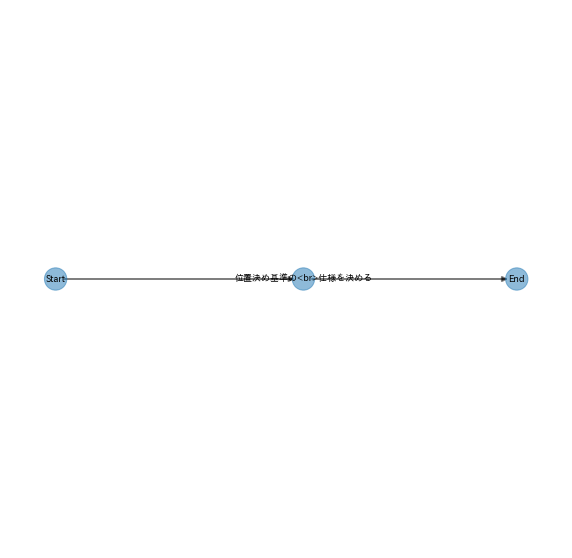

In [175]:
if __name__ == "__main__":
    """ メイン関数

    """
    # Windowを生成する。
    root = tk.Tk()

    app = Application(master=root)
    # Windowをループさせて、継続的にWindow表示させる。
    app.mainloop()
